# Upper Grindelwald case study

### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
fig_size = 12, 6
plt.rcParams['figure.figsize'] = (fig_size)  # Default plot size
import scipy.stats as stats
import numpy as np
import pandas as pd
import xarray as xr
import os
import shutil
import netCDF4
import salem
import copy
import datetime

import my_colors as mc

In [2]:
import oggm
from oggm import tasks
from oggm import cfg
from oggm import workflow
from oggm import utils
from oggm import graphics
from oggm.core.models import massbalance, flowline

from oggm.core.preprocessing.inversion import prepare_for_inversion
from oggm.core.preprocessing.inversion import invert_parabolic_bed

from oggm.core.preprocessing.climate import local_mustar_apparent_mb

In [3]:
cfg.initialize()  # read the default parameter file for OGGM
lengths_data = pd.read_csv(utils.get_demo_file('grindelwald_lengths_all.csv'), index_col=0)

### Init glacier directory

In [4]:
bdir = '/Users/oberrauch/bac/raw_data/grindelwald/'
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)

In [142]:
# filepaths
climate_file_path = gdir.get_filepath('climate_monthly')
original_file_path = climate_file_path.replace('climate_monthly.nc', 'climate_monthly_orig.nc')
climate_dir_path = os.path.dirname(climate_file_path)

if not os.path.exists(original_file_path):
    # copy original climate file as climate_monthly_orig.nc
    shutil.copy(climate_file_path, original_file_path);
    print('New climate file created from original...')
else:
    # delete modified file
    os.remove(climate_file_path)
    # rename original file
    os.rename(original_file_path, climate_file_path)
    # copy original climate file as climate_monthly_orig.nc
    shutil.copy(climate_file_path, original_file_path);
    print('Old climate file deleted and a new one created from original...')


ds = xr.open_dataset(climate_file_path)
# replace
ds['prcp'] = ds.prcp / 2.5 * 1.8
# ds['prcp'] = ds.prcp / 1.4
if os.path.exists(climate_file_path):
    os.remove(climate_file_path)
ds.to_netcdf(climate_file_path)

local_mustar_apparent_mb(gdir, tstar=1975, bias=0.)
prepare_for_inversion(gdir)

Old climate file deleted and a new one created from original...


### Mass-balance data

In [143]:
# We can build a mass-balance model based on
# these values and climate from HISTALP
mb_mod = massbalance.HistalpMassBalanceModel(gdir)

### Glen's flow law parameters

In [144]:
glen_a = cfg.A*1
y_start = 1879

## Check Toungue Width

In [145]:
out = invert_parabolic_bed(gdir, glen_a=glen_a, write=True)
# we keep the bed parabolic everywhere, just like for the inversion
cfg.PARAMS['bed_shape'] = 'parabolic'
flowline.init_present_time_glacier(gdir)
fls = gdir.read_pickle('model_flowlines')
u_fl = copy.deepcopy(fls[0])

In [145]:
out = invert_parabolic_bed(gdir, glen_a=glen_a, write=True)
# we keep the bed parabolic everywhere, just like for the inversion
cfg.PARAMS['bed_shape'] = 'parabolic'
flowline.init_present_time_glacier(gdir)
fls = gdir.read_pickle('model_flowlines')
u_fl = copy.deepcopy(fls[0])

In [146]:
# Make it flat
u_fl = copy.deepcopy(fls[0])
u_fl.bed_shape[60] = 7e-4
u_fl.bed_shape[61] = 6e-4
u_fl.bed_shape[62] = 5e-4
u_fl.bed_shape[63] = 4e-4
u_fl.bed_shape[64] = 3e-4
u_fl.bed_shape[65] = 2e-4
u_fl.bed_shape[66:] = 1e-4

In [10]:
# Now we are using "real time", so we have to define the
# starting year accordingly
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=y_start, 
                                fs=0., glen_a=glen_a)

In [11]:
# For every year where we have an observation,
# we are going to take the length of the glacier
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
y0 = years[0]
y1 = years[-1]
length = years*0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m

# add modelled lenght to ref_data
ref_data['oggm'] = length

In [12]:
# get actual lenght
y_ref = 1973
l_ref = 6650

l_ref_obs = ref_data['dl'][y_ref]
l_ref_mod = ref_data['oggm'][y_ref]

offset_obs = l_ref - l_ref_obs
offset_mod = l_ref - l_ref_mod

In [13]:
ref_data['dl'] += offset_obs

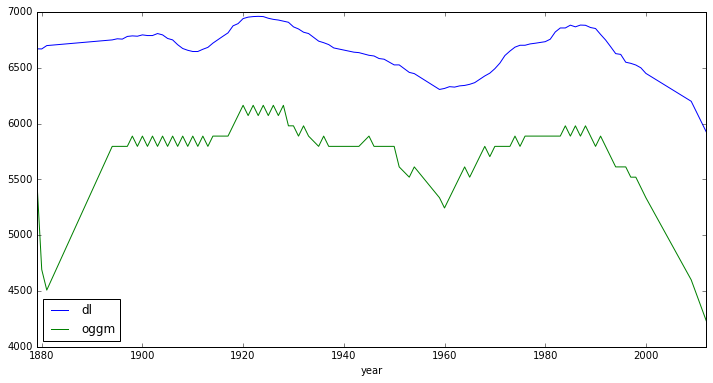

In [14]:
ref_data.plot();

In [15]:
ref_data['oggm'] += offset_mod

In [16]:
offset_mod

854.0

In [17]:
print(ref_data['oggm'][ref_data.axes[0][0]] - ref_data['oggm'][ref_data.axes[0][1]] - offset_mod)

-26.0


In [18]:
years_maps_all = np.array([1894, 1899, 1913, 1927, 1930, 1973, 1979, 1987, 1993, 1998, 2006, 2012, 2015])
years_maps = np.array([1894, 1899, 1913, 1927, 1930, 1973, 1976, 1979, 1981, 1987, 1993, 1998, 2006, 2012, 2015])

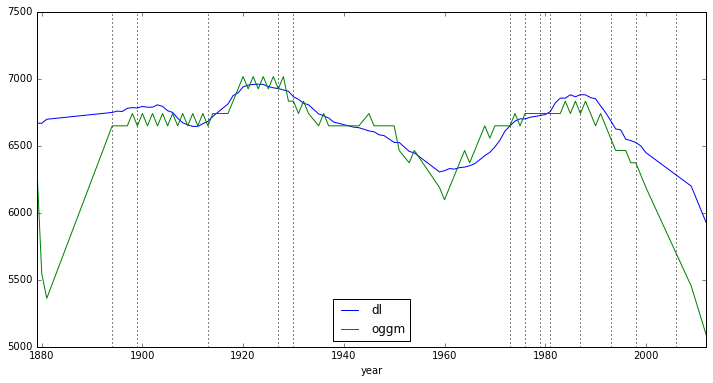

In [19]:
ref_data.plot();
for y in years_maps:
    plt.axvline(y, color='k', linestyle=':', lw=1)

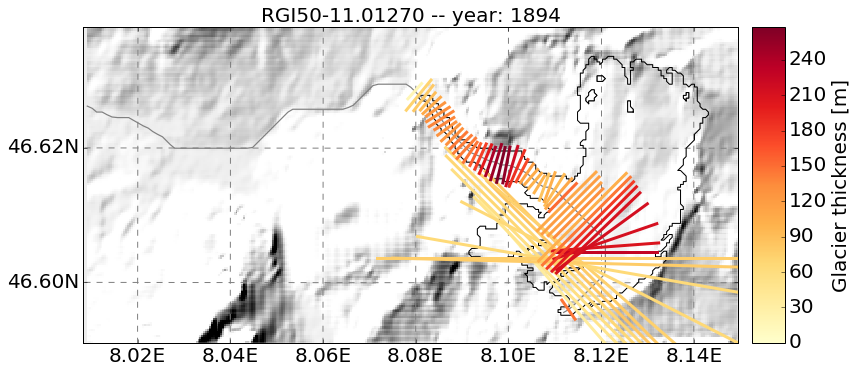

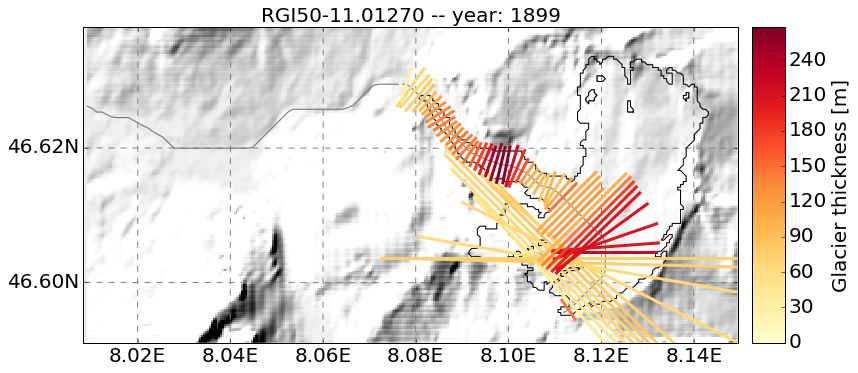

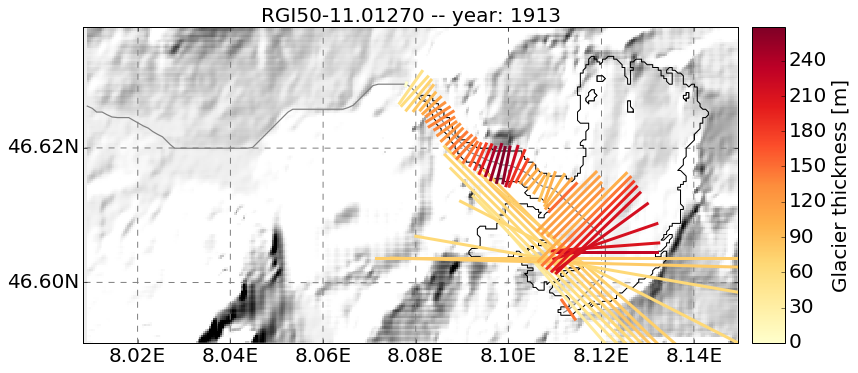

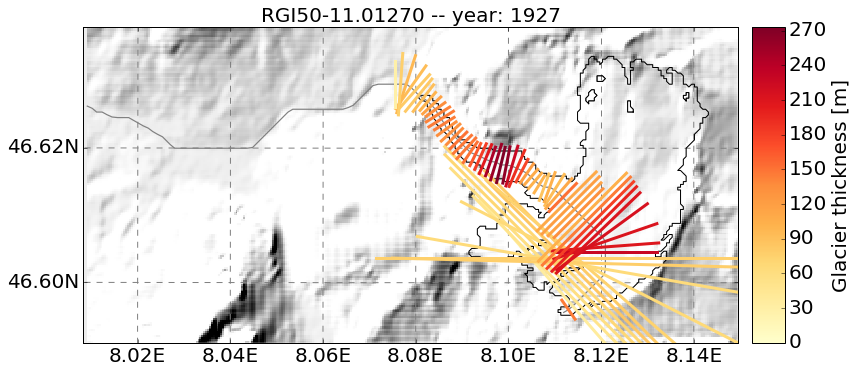

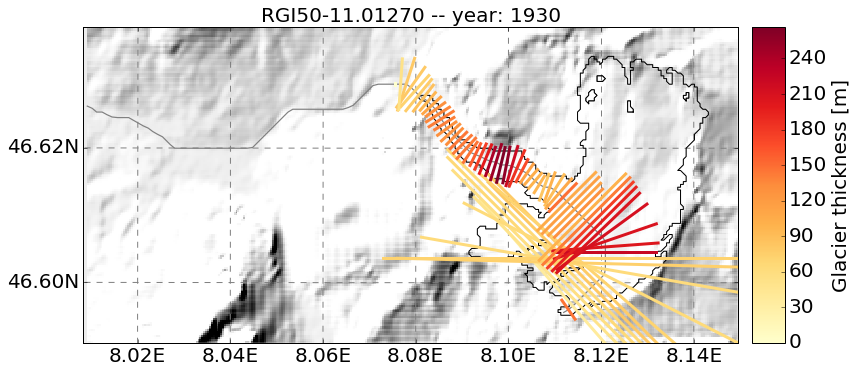

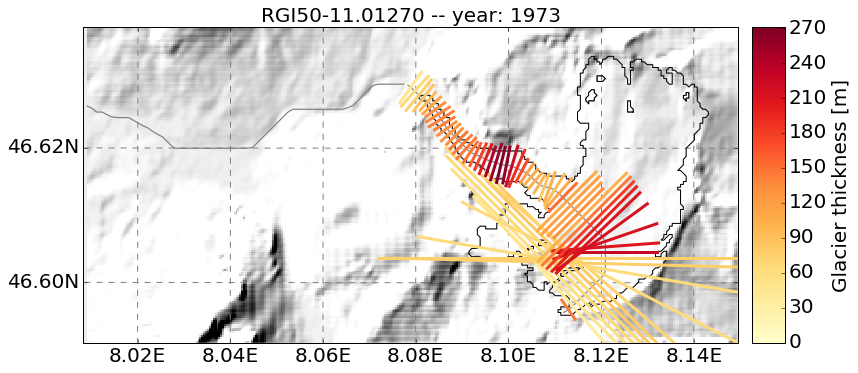

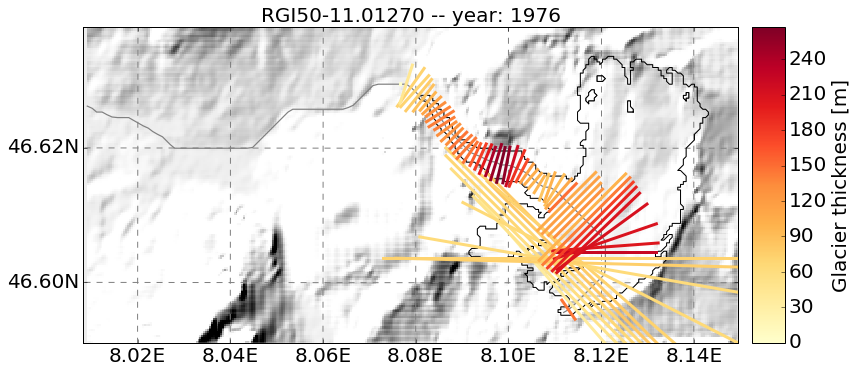

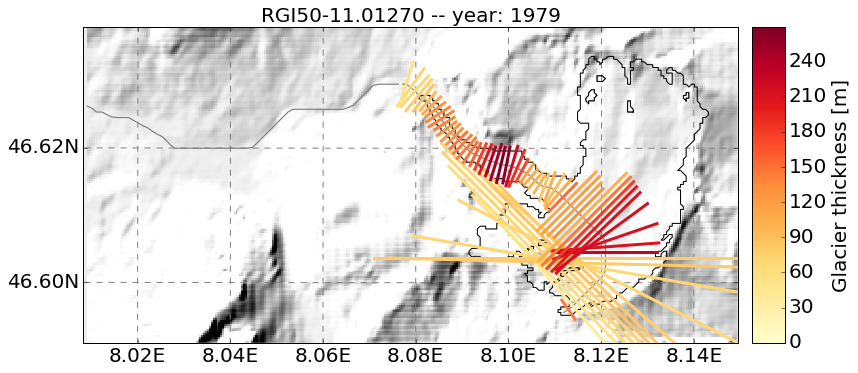

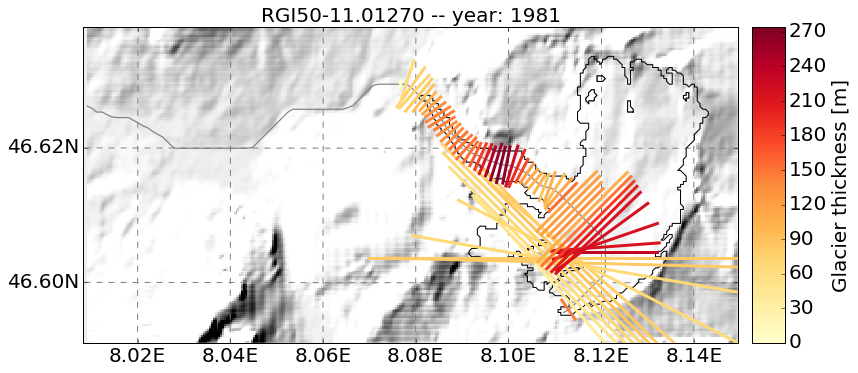

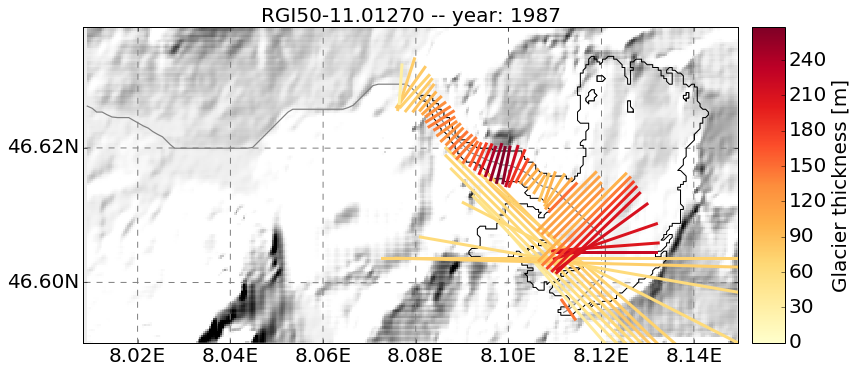

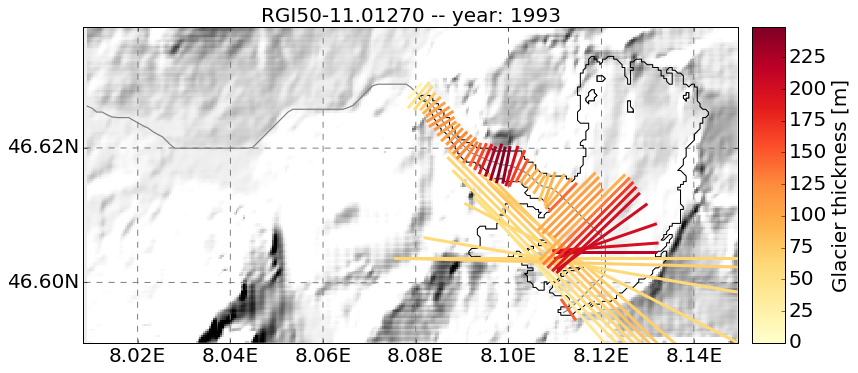

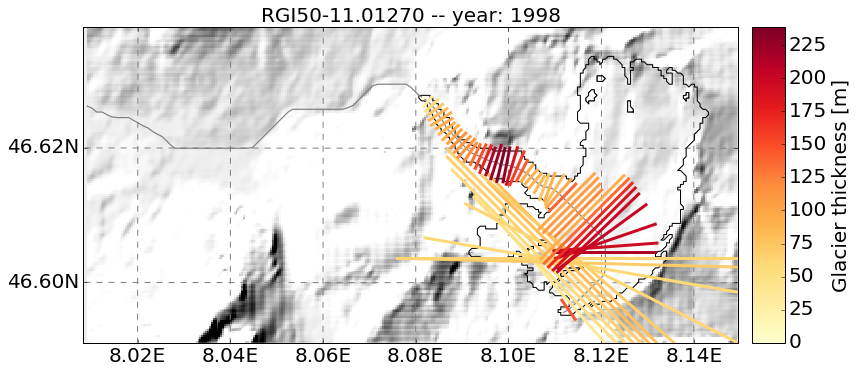

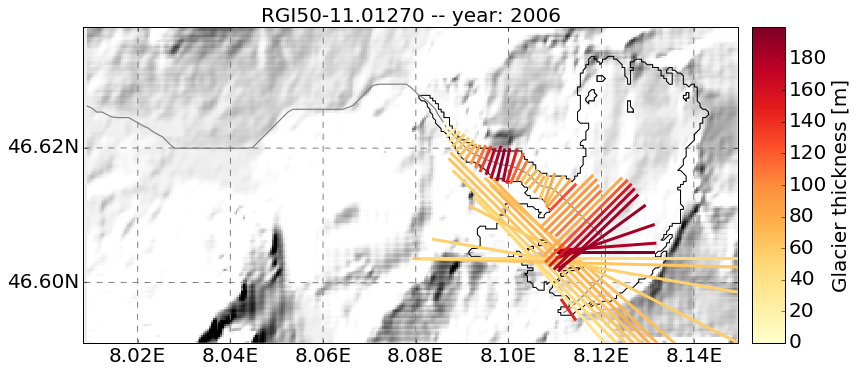

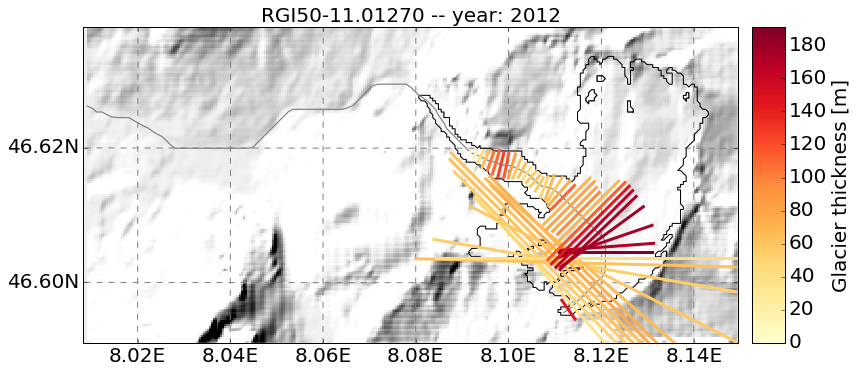

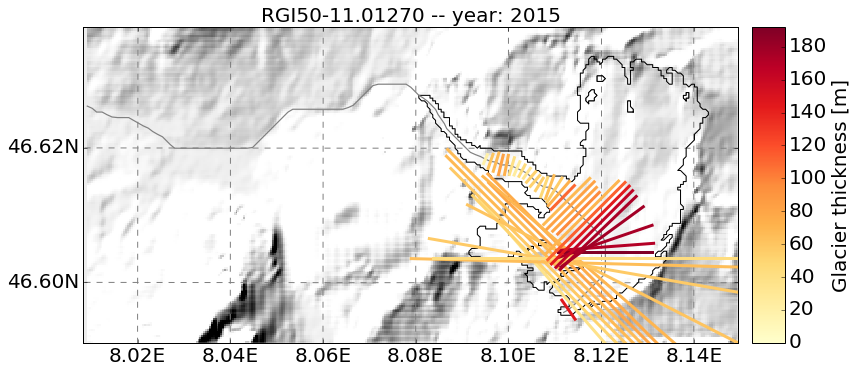

In [628]:
backwards_models = list()
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=1879., fs=0., glen_a=glen_a)

for y in years_maps:
    # See how a bigger glacier looks like
    model.run_until(y)
    graphics.plot_modeloutput_map(gdir, model=model)

In [630]:
"""Useful plotting functions"""
from __future__ import division
from six.moves import zip

from collections import OrderedDict
import warnings
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from matplotlib import transforms
import matplotlib.colors as colors
from matplotlib.ticker import NullFormatter

from descartes import PolygonPatch
import shapely.geometry as shpg
import glob
import os
import numpy as np
import netCDF4
import salem

from oggm.utils import entity_task

import cleo

# Local imports
import oggm.cfg as cfg


In [643]:
u_fl.dx * u_fl.map_dx 

92.0

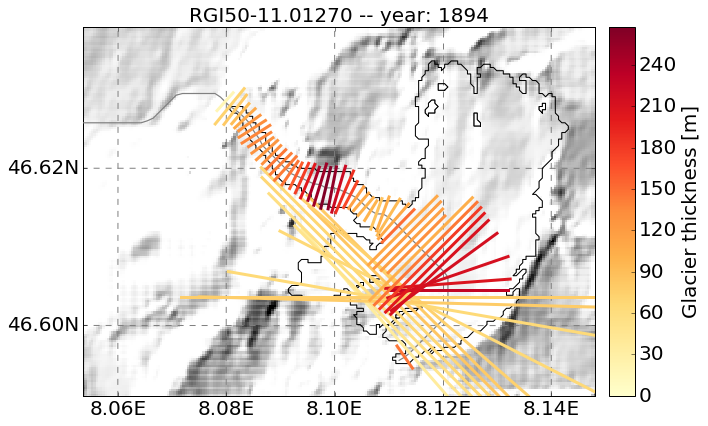

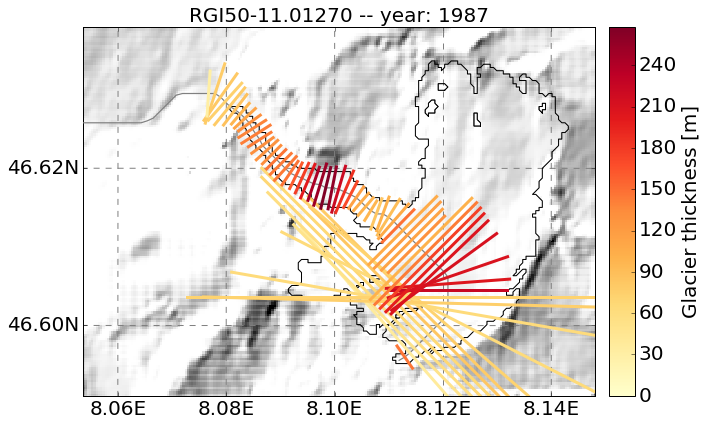

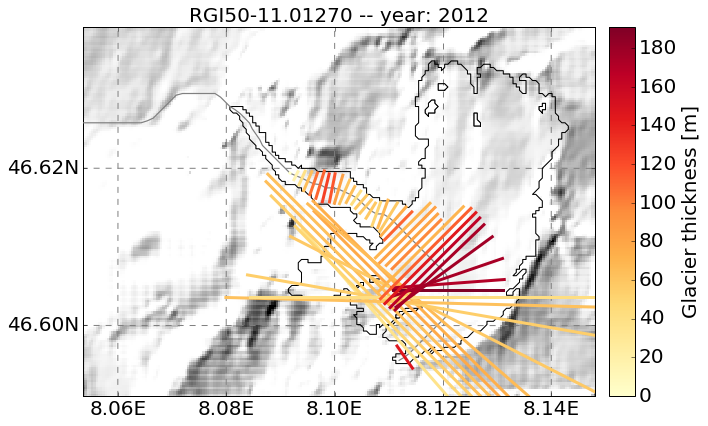

In [640]:
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], mb_model=mb_mod, y0=1879., fs=0., glen_a=glen_a)

for y in [1894, 1987, 2012]:
    # See how a bigger glacier looks like
    model.run_until(y)

    ax=None
    vmax=None

    dofig = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        dofig = True

    with netCDF4.Dataset(gdir.get_filepath('gridded_data')) as nc:
        topo = nc.variables['topo'][:]

    geom = gdir.read_pickle('geometries', div_id=0)
    poly_pix = geom['polygon_pix']

    ds = salem.GeoDataset(gdir.grid)
    mlines = shpg.GeometryCollection([l.line for l in model.fls] + [poly_pix])
    ml = mlines.bounds
    corners = ((ml[0], ml[1]), (ml[2], ml[3]))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=RuntimeWarning)
        ds.set_subset(corners=corners, margin=10, crs=gdir.grid)

    mp = cleo.Map(ds.grid, countries=False, nx=gdir.grid.nx)
    mp.set_topography(topo, crs=gdir.grid)

    # TODO: center grid or corner grid???
    crs = gdir.grid.center_grid
    mp.set_geometry(poly_pix, crs=crs, fc='none', zorder=2, linewidth=.2)
    for l in poly_pix.interiors:
        mp.set_geometry(l, crs=crs, color='black', linewidth=0.5)

    toplot_th = np.array([])
    toplot_lines = []

    # plot Centerlines
    cls = model.fls
    for l in cls:
        mp.set_geometry(l.line, crs=crs, color='gray',
                          linewidth=1.2, zorder=50)
        toplot_th = np.append(toplot_th, l.thick)
        widths = l.widths.copy()
        widths = np.where(l.thick > 0, widths, 0.)
        for wi, cur, (n1, n2) in zip(widths, l.line.coords, l.normals):
            l = shpg.LineString([shpg.Point(cur + wi/2. * n1),
                                 shpg.Point(cur + wi/2. * n2)])
            toplot_lines.append(l)

    cm = plt.cm.get_cmap('YlOrRd')
    dl = cleo.DataLevels(cmap=cm, nlevels=256, data=toplot_th, vmin=0, vmax=vmax)
    colors = dl.to_rgb()
    for l, c in zip(toplot_lines, colors):
        mp.set_geometry(l, crs=crs, color=c,
                          linewidth=3, zorder=50)
    mp.plot(ax)
    cb = dl.append_colorbar(ax, "right", size="5%", pad=0.2)
    cb.set_label('Glacier thickness [m]')
    tit = ' -- year: {:d}'.format(np.int64(model.yr))
    ax.set_title(gdir.rgi_id + tit)

    ax.set_xlim([110,340])

    if dofig:
        plt.tight_layout()

### Compare A Parameter

In [20]:
lat_ref = np.array([46.61832, 46.61801])
lon_ref = np.array([8.09603, 8.09613])
indices_ref = np.zeros(2)
distances = np.zeros(2)

gi, gj = u_fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

for k in [0,1]:
    dist = np.sqrt((lon_ref[k] - lon)**2 + (lat_ref[k] - lat)**2)
    ind_ = dist.argmin()
    indices_ref[k] = ind_
    distances[k] = dist[ind_]
    print('Index {}: Lat {}, Lon {}'.format(indices_ref[k], lat[ind_], lon[ind_]))

index = indices_ref[distances.argmin()]
print('Used index: {}'.format(index))

Index 42.0: Lat 46.61803799978403, Lon 8.096136937254617
Index 42.0: Lat 46.61803799978403, Lon 8.096136937254617
Used index: 42.0


/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


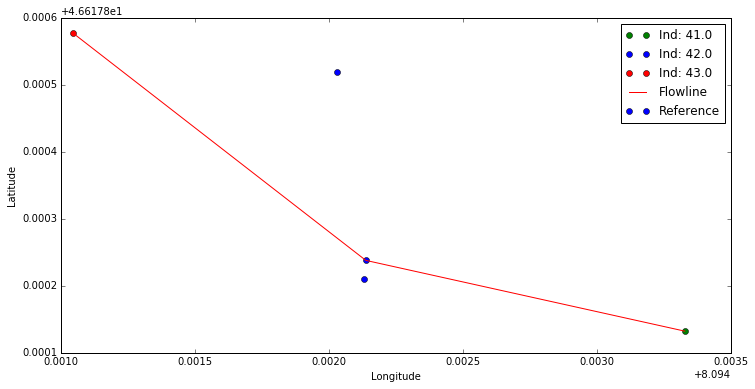

In [21]:
indices = np.arange(index-1, index+2, 1)
n_ind = indices.size
lats = np.zeros(n_ind)
longs = np.zeros(n_ind)
c = ['g', 'b', 'r']
for i, ind in enumerate(indices):
    plt.plot(lon[ind], lat[ind], label='Ind: {}'.format(ind), linestyle='none', marker='o', color=c[i]);
    lats[i] = lat[ind]
    longs[i] = lon[ind]

plt.plot(longs,lats, color='r', label='Flowline');
plt.plot(lon_ref, lat_ref, label='Reference', linestyle='none', marker='o', color='b');
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.legend();

378.240529031


/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


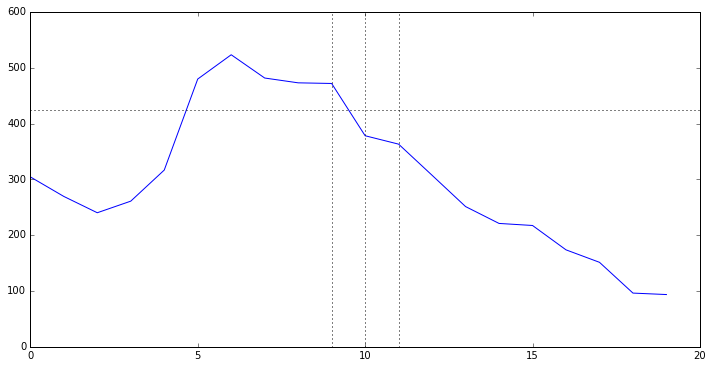

In [22]:
# Plot of the width around the closest point
width_meter = u_fl.widths * gdir.grid.dx
plt.plot(width_meter[index-10:index+10])
print(width_meter[index])
plt.axhline(425, color='k', linestyle=':')
plt.axvline(10, color='k', linestyle=':')
plt.axvline(11, color='k', linestyle=':')
plt.axvline(9, color='k', linestyle=':')

In [26]:
from collections import OrderedDict

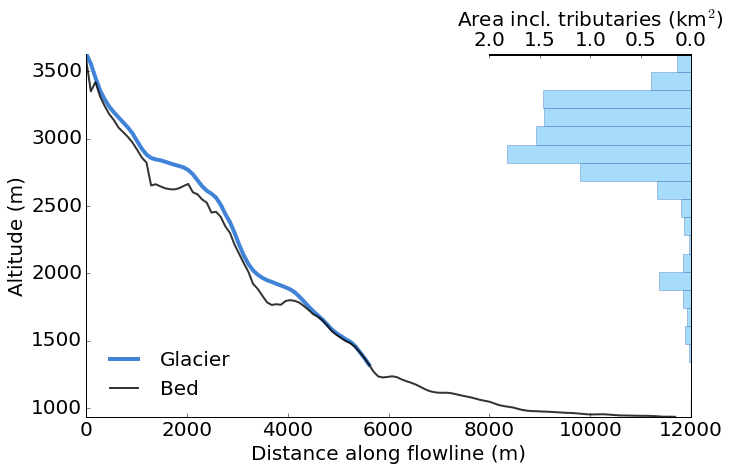

In [621]:
dofig = False
ax = None
title = ''
if ax is None:
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.07, 0.08, 0.7, 0.84])
    dofig = True

# Compute area histo
area = np.array([])
height = np.array([])
cls = model.fls[-1]
area = np.concatenate((area, cls.widths_m * cls.dx_meter * 1e-6))
height = np.concatenate((height, cls.surface_h))
ylim = [height.min(), height.max()]

# Plot histo
posax = ax.get_position()
posax = [posax.x0 + 2 * posax.width / 3.0,
         posax.y0,  posax.width / 3.0,
         posax.height]
axh = fig.add_axes(posax, frameon=False)

axh.hist(height, orientation='horizontal', range=ylim, bins=20,
         alpha=0.4, weights=area, color='#22A7F0', edgecolor='#4B77BE')
axh.invert_xaxis()
axh.xaxis.tick_top()
axh.set_xlabel('Area incl. tributaries (km$^2$)')
axh.xaxis.set_label_position('top')
axh.set_ylim(ylim)
axh.yaxis.set_ticks_position('right')
axh.set_yticks([])
axh.axhline(y=ylim[1], color='black', alpha=1)  # qick n dirty trick

# plot Centerlines
x = np.arange(cls.nx) * cls.dx * cls.map_dx

# Where trapezoid change color
if hasattr(cls, '_dot') and cls._dot:
    bed_t = cls.bed_h * np.NaN
    bed_t[cls._pt] = cls.bed_h[cls._pt]
    ax.plot(x, bed_t, color='#990000', linewidth=2.5, label='Bed (Trap.)')

# Plot tributaries
for i, l in zip(cls.inflow_indices, cls.inflows):
    if l.thick[-1] > 0:
        ax.plot(x[i], cls.surface_h[i], 's', color='#993399',
                label='Tributary (active)')
    else:
        ax.plot(x[i], cls.surface_h[i], 's', color='none',
                label='Tributary (inactive)')

# Plot glacier
surfh = cls.surface_h
pok = np.where(cls.thick == 0.)[0]
if (len(pok) > 0) and (pok[0] < (len(surfh)-1)):
    surfh[pok[1]+1:] = np.NaN
ax.plot(x, surfh, color='#4183D7', linewidth=4, label='Glacier')
        
# Plot the bed
ax.plot(x, cls.bed_h, color='k', linewidth=2, label='Bed', alpha=0.8)


ax.set_ylim(ylim)

ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Distance along flowline (m)')
ax.set_ylabel('Altitude (m)')

# Title
ax.set_title(title, loc='left')

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc=3,
#          bbox_to_anchor=(1.34, 1.0),
          frameon=False)



In [620]:
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=y_start, 
                                fs=0., glen_a=glen_a)

In [618]:
model.run_until(1900)

In [557]:
indices

array([ 41.,  42.,  43.])

/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


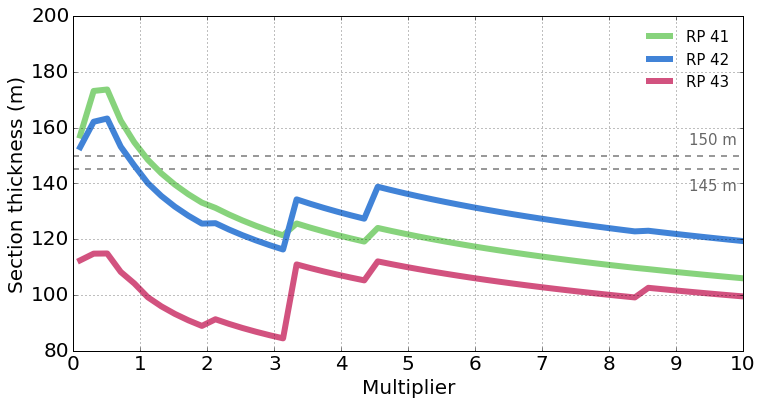

In [582]:
matplotlib.rc('legend', frameon=False)

factor = np.linspace(0.1, 10, 50)
thick = factor*0

y_ref_1 = 150
y_ref_2 = 145
c='0.4'

plt.axhline(y_ref_1, c='0.6', lw='2', ls='--')
plt.axhline(y_ref_2, c='0.6', lw='2', ls='--')

x_t = 9.2
y_os = 3
fs=15

plt.text(x_t, y_ref_1+y_os, '150 m', va='bottom', fontsize=fs, color=c)
plt.text(x_t, y_ref_2-y_os, '145 m', va='top', fontsize=fs, color=c)

labels = ['RP 41', 'RP 42', 'RP 43']
colors = ['#87D37C', '#4183D7', '#D2527F']

indices = np.arange(index-1, index+2, 1)

for k, ind in enumerate(indices):
    for i, f in enumerate(factor):
        vol_m3, area_m3 = invert_parabolic_bed(gdir, glen_a=glen_a*f)
        out = gdir.read_pickle('inversion_output', div_id=1)
        thick[i] = out[0]['thick'][ind]
    plt.plot(factor, thick, label=labels[k], color=colors[k], lw=6);
        
plt.xticks(np.arange(11))
plt.yticks(np.arange(80, 201, 20))
plt.ylabel('Section thickness (m)');
plt.xlabel('Multiplier');
plt.grid()
plt.legend(loc=1, fontsize=15);

### Maximum temperature

In [507]:
# open climate file
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))

In [541]:
annual_precip = d.prcp.resample(freq='AS', dim='time', how=np.mean).to_series()

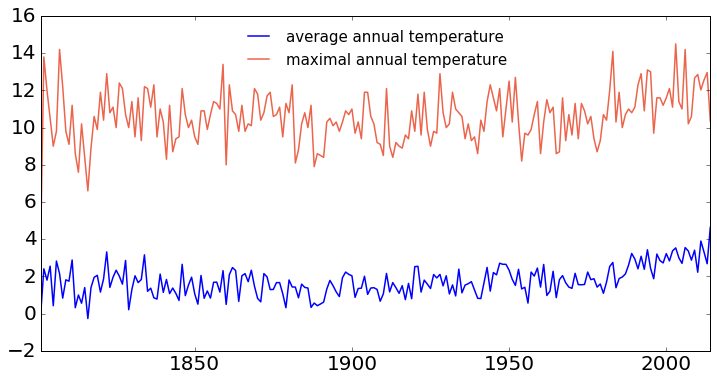

In [508]:
# calc max annual temperature
annual_temp = d.temp.resample(freq='AS', dim='time', how=np.mean).to_series()
annual_temp_max = d.temp.resample(freq='AS', dim='time', how=np.max).to_series()

annual_temp = pd.Series(annual_temp.values, index=annual_temp.index.year)
annual_temp_max = pd.Series(annual_temp_max.values, index=annual_temp_max.index.year)

# calc arithmetic mean
mean_temp = annual_temp_max.mean()

# plot max vs. mean annual temperature
ax = annual_temp.plot(label='average annual temperature', color='b');
ax = annual_temp_max.plot(label='maximal annual temperature', color='#EC644B');
plt.legend(loc=0)

### Compare mass-balancem, max temperature and length change

In [509]:
# calc mass-balance
years_mb = np.arange(1802, 2015, 1)
spec_mb = years_mb * 0.
for i, y in enumerate(years_mb):
    mb_onh = mb_mod.get_mb(u_fl.surface_h, year=y) * oggm.cfg.SEC_IN_YEAR
    spec_mb[i] = np.average(mb_onh, weights=u_fl.widths)
spec_mb = pd.Series(spec_mb, index=years_mb)

In [510]:
# modify plot properties
matplotlib.rc('lines', linewidth=3)

matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=15)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

matplotlib.rc('legend', fontsize=15)
matplotlib.rc('legend', frameon=False)

In [511]:
mc.length_color_2

'#EC644B'

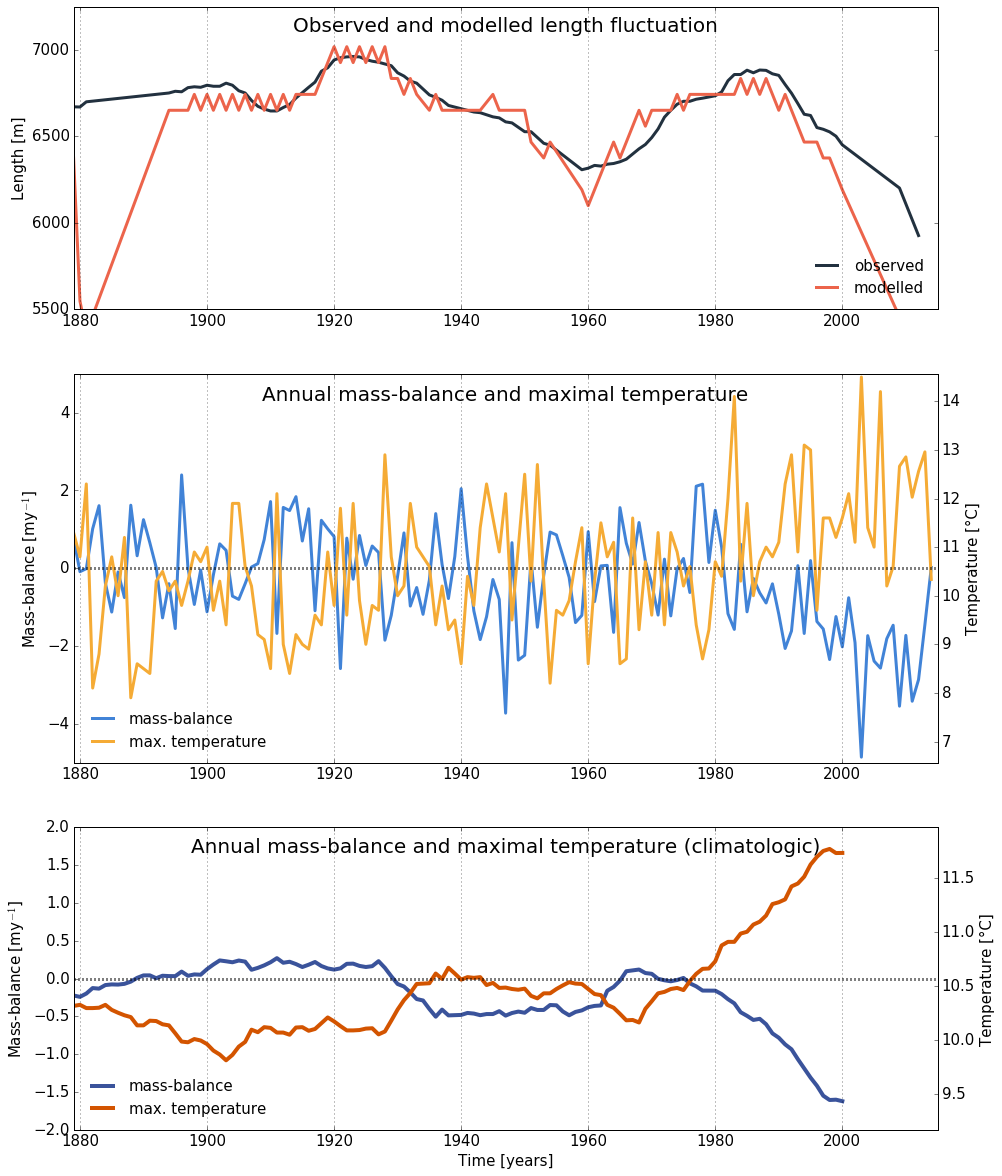

In [512]:
# create a figure
fig = plt.figure();

# set y-axis properties
yprops = dict(rotation=0,  
              horizontalalignment='right',
              verticalalignment='center',
              x=-0.01)

# add a new subfigure
ax1 = fig.add_axes([0, 1.9, 1, 0.7])
# plot the lenght fluctuation
ref_data.plot(ax=ax1, color=[mc.length_color_1, mc.length_color_2], legend=False);

# axes-limits
ax1.set_xlim([y0,y1]);
ax1.set_ylim([5500,7250]);

# labels and title
ax1.set_xlabel('')
ax1.set_ylabel('Length [m]')
ax1.set_title('Observed and modelled length fluctuation', position=(0.5, 0.9));

# legend
ax1.legend(labels=['observed', 'modelled'], loc=4) 

# plot a grid
ax1.grid(axis='x')

# create a new subfigure
ax2 = fig.add_axes([0, 0.85, 1, 0.9])
# plot mass-balance
ax2.plot(spec_mb, label='mass-balance', color=mc.mb_color_1);

# axes-limits
ax2.set_xlim([y0,y1])
ax2.set_ylim([-5, 5])

# labels and title
ax2.set_ylabel('Mass-balance [my$^{-1}$]')
ax2.set_title('Annual mass-balance and maximal temperature', position=(0.5, 0.92))
# legend
h_ax2, l_ax2 = ax2.get_legend_handles_labels()

# get a second y-axis
ax3 = ax2.twinx()
# plot maximal annual temperature
ax3.plot(annual_temp_max, label='max. temperature', color=mc.temp_color_1);

# axes-limits
ax3.set_xlim([y0,y1])
ax3.set_ylim([mean_temp-4, mean_temp+4])

# horizontal guide line
ax3.axhline(mean_temp, color='k', linestyle=':')
ax2.grid(axis='x')

# labels and title
ax3.set_ylabel('Temperature [°C]')
ax3.set_xlabel('Time [years]')

# legend
h_ax3, l_ax3 = ax3.get_legend_handles_labels()
handle = [h_ax2[0], h_ax3[0]]
label = [l_ax2[0], l_ax3[0]]
ax3.legend(handle, label, loc=3)

# add another figure
ax4 = fig.add_axes([0, 0, 1, 0.7])

# calc and plot rolling mean over mass-balance
mb_rolling = spec_mb.rolling(30, center=True).mean()
ax4.plot(mb_rolling, label='mass-balance', color=mc.mb_color_2, lw=4);

# axes-limits
ax4.set_xlim([y0,y1])
ax4.set_ylim([-2, 2])

# labels and title
ax4.set_ylabel('Mass-balance [my$^{-1}$]')
ax4.set_xlabel('Time [years]')
ax4.set_title('Annual mass-balance and maximal temperature (climatologic)', position=(0.5, 0.9))

# legend
h_ax4, l_ax4 = ax4.get_legend_handles_labels()

# get a second y-axis
ax5 = ax4.twinx()

# calc and plot rolling mean over T_max
temp_max_rolling = annual_temp_max.rolling(30, center=True).mean()
ax5.plot(temp_max_rolling, label='max. temperature', color=mc.temp_color_2, lw=4);

# horizontal guide line
ax5.axhline(mean_temp, color='k', linestyle=':')
ax4.grid(axis='x')

# axes-limits
ax5.set_xlim([y0,y1])
ax5.set_ylim([mean_temp-1.4, mean_temp+1.4])

# Labels and title
ax5.set_ylabel('Temperature [°C]')
ax5.set_xlabel('Time [years]')

# legend
h_ax5, l_ax5 = ax5.get_legend_handles_labels()
handle = [h_ax4[0], h_ax5[0]]
label = [l_ax4[0], l_ax5[0]]
ax5.legend(handle, label, loc=3)

In [545]:
a = annual_precip.rolling(30, center=True).mean()
a.loc['1975-01-01':]

time
1975-01-01    335.672190
1976-01-01    336.275533
1977-01-01    336.934799
1978-01-01    338.962299
1979-01-01    340.970511
1980-01-01    343.005899
1981-01-01    340.852918
1982-01-01    338.874764
1983-01-01    339.683562
1984-01-01    336.182362
1985-01-01    339.313859
1986-01-01    337.465922
1987-01-01    339.355718
1988-01-01    342.770277
1989-01-01    340.648436
1990-01-01    340.341862
1991-01-01    338.441275
1992-01-01    339.225662
1993-01-01    337.662666
1994-01-01    336.318628
1995-01-01    333.610780
1996-01-01    332.582067
1997-01-01    326.791790
1998-01-01    327.538995
1999-01-01    329.966434
2000-01-01    334.399305
2001-01-01           NaN
2002-01-01           NaN
2003-01-01           NaN
2004-01-01           NaN
2005-01-01           NaN
2006-01-01           NaN
2007-01-01           NaN
2008-01-01           NaN
2009-01-01           NaN
2010-01-01           NaN
2011-01-01           NaN
2012-01-01           NaN
2013-01-01           NaN
2014-01-01          

In [525]:
a = [2000, 2009]
b = [ref_data.dl.loc[2000] ,ref_data.dl.loc[2009]]
a_,b_,_,_,_ = stats.linregress(a,b)

In [532]:
l_ = 2003*a_+b_
l_

6366.6666666666642

(1999, 2010)

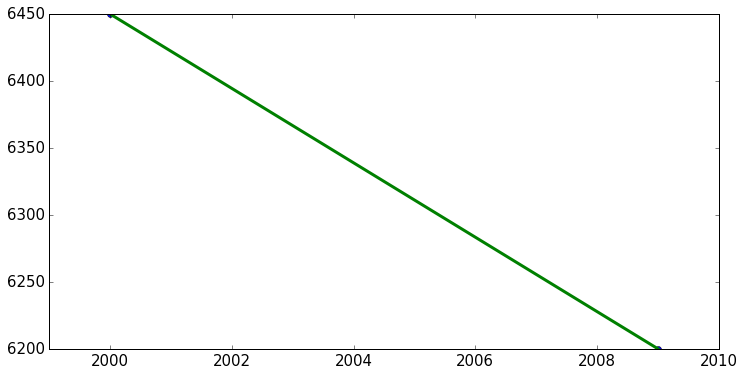

In [530]:
plt.plot(a,b, linestyle='none', marker='o')
b__ = np.array(a)*a_+b_
plt.plot(a, b__)
plt.xlim([1999,2010])

In [513]:
ref_data

dl    oggm
year              
1879  6670  6374.0
1880  6669  5546.0
1881  6699  5362.0
1894  6750  6650.0
1895  6760  6650.0
1896  6757  6650.0
1897  6781  6650.0
1898  6786  6742.0
1899  6783  6650.0
1900  6795  6742.0
1901  6789  6650.0
1902  6789  6742.0
1903  6807  6650.0
1904  6795  6742.0
1905  6763  6650.0
1906  6750  6742.0
1907  6707  6650.0
1908  6673  6742.0
1909  6657  6650.0
1910  6646  6742.0
1911  6646  6650.0
1912  6666  6742.0
1913  6683  6650.0
1914  6721  6742.0
1916  6783  6742.0
1917  6813  6742.0
1918  6876  6834.0
1919  6896  6926.0
1920  6941  7018.0
1921  6954  6926.0
...    ...     ...
1973  6650  6650.0
1974  6685  6742.0
1975  6702  6650.0
1976  6702  6742.0
1977  6714  6742.0
1978  6720  6742.0
1979  6727  6742.0
1980  6734  6742.0
1981  6756  6742.0
1982  6821  6742.0
1983  6857  6742.0
1984  6857  6834.0
1985  6882  6742.0
1986  6867  6834.0
1987  6883  6742.0
1988  6881  6834.0
1989  6861  6742.0
1990  6852  6650.0
1991  6799  6742.0
1992  6749  6650.0
1993  6689  6558.0
1994  6627  6466.0
1995  6620  6466.0
1996  6550  6466.0
1997  6540  6374.0
1998  6525  6374.0
1999  6500  6282.0
2000  6450  6190.0
2009  6200  5454.0
2012  5925  5086.0

[100 rows x 2 columns]

In [24]:
a = temp_max_rolling.loc[1879:2000]
b = mb_rolling.loc[1879:2000]

In [25]:
k, d, r, p, std_err = stats.linregress(a,b)

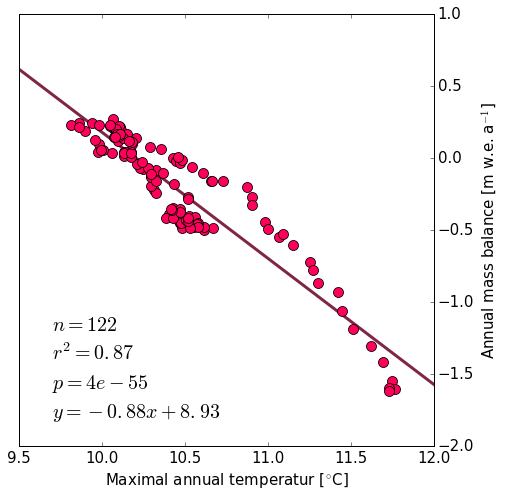

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.48,1])

x = np.array([9.5,12])
y = k*x + d

ax.plot(x,y, label='linear regression line', color='#7F2646')

ax.plot(a, b, linestyle='none', markeredgecolor='k', marker='o', 
        color='#FF005A', markeredgewidth='0.8', markersize='10',
        label='points')

ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

ax.set_ylabel('Annual mass balance [m w.e. a$^{-1}$]')
ax.set_xlabel('Maximal annual temperatur [$^{\circ}$C]')

x_t = 9.7
y_t = -1.4
d_t = 0.2

ax.text(x_t, y_t+d_t, r'$n = {}$'.format(122), fontsize=20)
ax.text(x_t, y_t, r'$r^2 = {}$'.format(round(r**2,2)), fontsize=20)
ax.text(x_t, y_t-d_t, r'$p = {:.0e}$'.format(p), fontsize=20)
ax.text(x_t, y_t-2*d_t, r'$y = {:4.2f}x + {:4.2f}$'.format(k, d), fontsize=20)

#ax.legend(loc=3, numpoints=1)

In [27]:
a_ = annual_temp_max.loc[1879:2015]
b_ = spec_mb.loc[1879:2015]

In [28]:
k_, d_, r_, p_, std_err_ = stats.linregress(a_,b_)

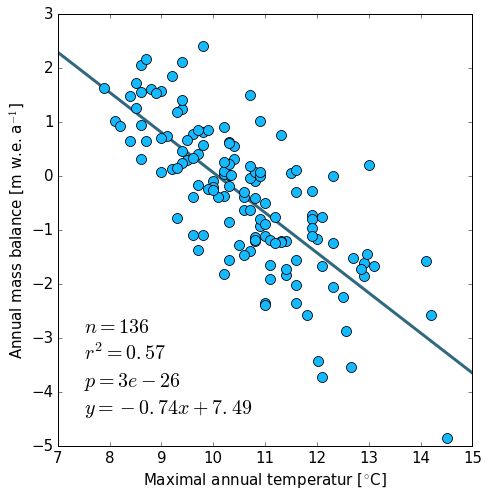

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,0.48,1])

x = np.array([7,15])
y = k_*x + d_
ax.plot(x,y, label='linear regression line', color='#30687F')

ax.plot(a_, b_, linestyle='none', color='#14B9FF', marker='o',
        markeredgecolor='k', markeredgewidth='0.8', markersize='10',
        label='points')

ax.set_xlabel('Maximal annual temperatur [$^{\circ}$C]')
ax.set_ylabel('Annual mass balance [m w.e. a$^{-1}$]')

x_t = 7.5
y_t = -3.4
d_t = 0.5

ax.text(x_t, y_t+d_t, r'$n = {}$'.format(136), fontsize=20)
ax.text(x_t, y_t, r'$r^2 = {}$'.format(round(r_**2,2)), fontsize=20)
ax.text(x_t, y_t-d_t, r'$p = {:.0e}$'.format(p_), fontsize=20)
ax.text(x_t, y_t-2*d_t, r'$y = {:4.2f}x + {:4.2f}$'.format(k_, d_), fontsize=20)

#ax.legend(loc=3, numpoints=1)

In [1]:
# create a figure
fig = plt.figure();

# set y-axis properties
yprops = dict(rotation=0,  
              horizontalalignment='right',
              verticalalignment='center',
              x=-0.01)

# add a new subfigure
ax1 = fig.add_axes([0, 1.3, 1, 0.5])
# plot the lenght fluctuation
ref_data.plot(ax=ax1, color=[mc.length_color_1, mc.length_color_2], legend=False);

# axes-limits
ax1.set_xlim([y0,y1]);
ax1.set_ylim([6000,7250]);

# labels and title
ax1.set_xlabel('')
ax1.set_ylabel('Length [m]')
ax1.set_title('Observed and modelled length fluctuation', position=(0.5, 0.88));

# legend
ax1.legend(labels=['observed', 'modelled'], loc=4) 

# plot a grid
ax1.grid(axis='x')

# create a new subfigure
ax2 = fig.add_axes([0, 0.65, 1, 0.5])
# plot mass-balance
ax2.plot(spec_mb, label='annual', color=mc.mb_color_1);

# axes-limits
ax2.set_xlim([y0,y1])
ax2.set_ylim([-4, 4])

# guide lines
ax2.grid(axis='x')
ax2.axhline(0, color='k', linestyle=':')

# labels and title
ax2.set_ylabel('Mass-balance [my$^{-1}$]')
# legend
h_ax2, l_ax2 = ax2.get_legend_handles_labels()

# get a second y-axis
ax3 = ax2.twinx()

# calc and plot rolling mean over mass-balance
mb_rolling = spec_mb.rolling(30, center=True).mean()
ax3.plot(mb_rolling, label='climatologic', color=mc.mb_color_2, lw=2.5);

# axes-limits
ax3.set_xlim([y0,y1])
ax3.set_ylim([-2, 2])

# labels and title
ax3.set_ylabel('Mass-balance [my$^{-1}$]')
ax3.set_xlabel('Time [years]')
ax3.set_title('Annual mass-balance', position=(0.5, 0.88))

# legend
h_ax3, l_ax3 = ax3.get_legend_handles_labels()
handle = [h_ax2[0], h_ax3[0]]
label = [l_ax2[0], l_ax3[0]]
ax3.legend(handle, label, loc=3)

ax4 = fig.add_axes([0, 0, 1, 0.5])

# plot maximal annual temperature
ax4.plot(annual_temp_max, label='annual', color=mc.temp_color_1);

# axes-limits
ax4.set_xlim([y0,y1])
ax4.set_ylim([mean_temp-4, mean_temp+4])

# horizontal guide line
ax4.axhline(mean_temp, color='k', linestyle=':')
ax4.grid(axis='x')

# labels and title
ax4.set_ylabel('Temperature [°C]')
ax4.set_xlabel('Time [years]')
ax4.set_title('Maximum annual temperature', position=(0.5, 0.88))

# legend
h_ax4, l_ax4 = ax4.get_legend_handles_labels()

# get a second y-axis
ax5 = ax4.twinx()

# calc and plot rolling mean over T_max
temp_max_rolling = annual_temp_max.rolling(30, center=True).mean()
ax5.plot(temp_max_rolling, label='climatologic', color=mc.temp_color_2, lw=2.5);

# horizontal guide line
ax5.axhline(mean_temp, color='k', linestyle=':')
ax4.grid(axis='x')

# axes-limits
ax5.set_xlim([y0,y1])
ax5.set_ylim([mean_temp-1.4, mean_temp+1.4])

# Labels and title
ax5.set_ylabel('Temperature [°C]')
ax5.set_xlabel('Time [years]')
# legend
h_ax5, l_ax5 = ax5.get_legend_handles_labels()
handle = [h_ax4[0], h_ax5[0]]
label = [l_ax4[0], l_ax5[0]]
ax5.legend(handle, label, loc=4)

NameError: name 'plt' is not defined

### Get Season Indices

In [97]:
temp_season_mean = d.temp.resample(freq='QS-DEC', dim='time', how=np.mean)
temp_season_max = d.temp.resample(freq='QS-DEC', dim='time', how=np.max)

In [98]:
seasons_name = list(['spring', 'summer', 'autumn', 'winter'])
seasons_months = list(['MAM', 'JJA', 'SON', 'DJF'])
seasons = temp_season_max['time.season']
seasons_ind = dict()
for i, season in enumerate(seasons_months):
    name = seasons_name[i]
    seasons_ind[name] = np.nonzero(seasons.values == season)

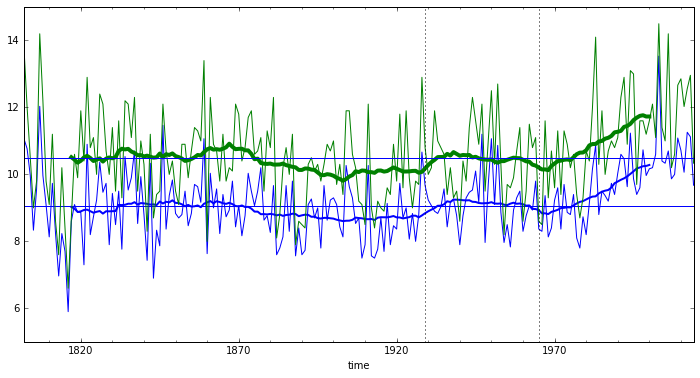

In [100]:
ts_mean = temp_season_mean[seasons_ind['summer']].to_series()
ax = ts_mean.plot(label='average', color='b')
ts_mean_rolling = ts_mean.rolling(30, center=True).mean()
ts_mean_rolling.plot(label='rolling mean over 30 years', color='b', lw=2);
plt.axhline(ts_mean_rolling.mean())

ts_max = temp_season_max[seasons_ind['summer']].to_series()
ax = ts_max.plot(label='max', color='g')
ts_max_rolling = ts_max.rolling(30, center=True).mean()
ts_max_rolling.plot(label='rolling mean over 30 years', color='g', lw=4);
plt.axhline(ts_max_rolling.mean())



plt.axvline(datetime.date(1929, 1, 1), color='k', linestyle=':')
plt.axvline(datetime.date(1965, 1, 1), color='k', linestyle=':')

In [ ]:
a.keys()[0]

In [ ]:
a = datetime.date(1820, 1, 1)

In [ ]:
c = temp_season_max[seasons_ind['summer']].to_series()
c.plot()
d = b.rolling(30, center=True).mean()
d.plot(label='rolling mean over 30 years', color='g', lw=2);
plt.axhline(c.mean())

## Height a the cave entraces

In [23]:
lat_ref = np.array([46.61832, 46.61801])
lon_ref = np.array([8.09603, 8.09613])
indices_ref = np.zeros(2)
distances = np.zeros(2)

gi, gj = u_fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

for k in [0,1]:
    dist = np.sqrt((lon_ref[k] - lon)**2 + (lat_ref[k] - lat)**2)
    ind_ = dist.argmin()
    indices_ref[k] = ind_
    distances[k] = dist[ind_]
    print('Index {}: Lat {}, Lon {}'.format(indices_ref[k], lat[ind_], lon[ind_]))

index = indices_ref[distances.argmin()]
print('Used index: {}'.format(index))

Index 42.0: Lat 46.61803799978403, Lon 8.096136937254617
Index 42.0: Lat 46.61803799978403, Lon 8.096136937254617
Used index: 42.0


In [24]:
for ind_ in [46,47,48]:
    print('Index {}: Lat {}, Lon {}'.format(ind_, lat[ind_], lon[ind_]))

Index 46: Lat 46.61939540704246, Lon 8.091761683509155
Index 47: Lat 46.61998064216633, Lon 8.090911708701794
Index 48: Lat 46.62056587091129, Lon 8.090061715578079


In [25]:
lat_cave = 46.6167
lon_cave = 8.08333

gi, gj = u_fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

dist = np.sqrt((lon_cave - lon)**2 + (lat_cave - lat)**2)
index_cave = dist.argmin()
distance = dist[index_cave]
print('Index {}: Lat {}, Lon {}'.format(index_cave, lat[index_cave], lon[index_cave]))

print('Used index: {}'.format(index_cave))

Index 51: Lat 46.62232151886877, Lon 8.08751162630308
Used index: 51


#### Cave entraces with new coordinates

In [423]:
n_caves = 5
caves = ['E1', 'E2: BL-1840', 'E3: BL-1750', 'E5', 'E4: BL-1650']
lat_caves = np.array([46.624071981, 46.618130279, 46.618768249, 46.619290335, 46.619587094])
lon_caves = np.array([8.084296603, 8.089826384, 8.089951579, 8.089892598, 8.089909233])
h_caves = np.array([1601, 1885, 1794, 1740, 1697])
h_caves_rel = np.array([np.nan, 188, 97, 43, 0])

In [27]:
ind_caves = np.zeros(n_caves)
distances = np.zeros(n_caves)

gi, gj = u_fl.line.xy
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

for i in range(0, n_caves):
    lon_cave = lon_caves[i]
    lat_cave = lat_caves[i]
    dist = np.sqrt((lon_cave - lon)**2 + (lat_cave - lat)**2)
    ind_caves[i] = dist.argmin()
    distances[i] = dist[index_cave]

In [28]:
for i in range(0, n_caves):
    print('cave {} uses index {} with a distance of {}'.format(caves[i], ind_caves[i], distances[i]))

cave E1 uses index 55.0 with a distance of 0.003660668314967023
cave E2: BL-1840 uses index 47.0 with a distance of 0.004787963537147624
cave E3: BL-1750 uses index 47.0 with a distance of 0.004310347540923553
cave E5 uses index 47.0 with a distance of 0.0038544911295571166
cave E4: BL-1650 uses index 48.0 with a distance of 0.0036367014224519775


In [29]:
# modify plot properties
matplotlib.rc('lines', linewidth=1.5)

matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=25)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

matplotlib.rc('legend', fontsize=20)
matplotlib.rc('legend', frameon=False)

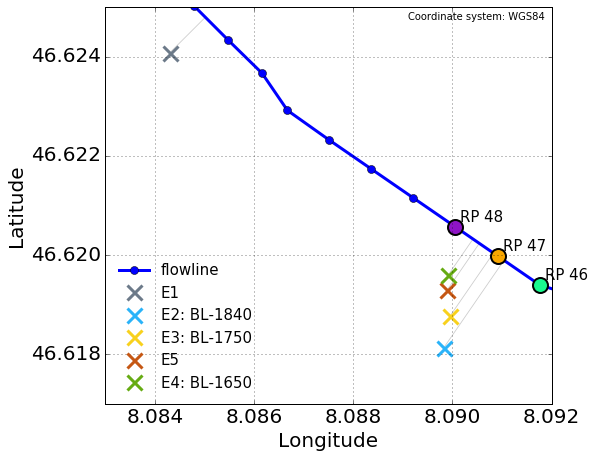

In [132]:
color_caves = ['#6C7A89', '#2AB3F9', '#F8D11D', '#C55713', '#66AB13']

plt.figure(figsize=[8,8])


for i in range(0, n_caves):
    l_x = lon[inds[i]]
    l_y = lat[inds[i]]

    p_x = lon_caves[i]
    p_y = lat_caves[i]
    
    x = np.array([p_x,points_i[i][0]])
    y = k_s[i]*x + d_s[i]
    plt.plot(x,y, '0.8', lw=0.8)

plt.plot(lon, lat, linestyle='-', marker='o', lw=3, markersize='8', label='flowline')
plt.plot(lon_ref, lat_ref, marker='o')
for i in range(0, n_caves):
    plt.plot(lon_caves[i], lat_caves[i], marker='x', linestyle='none', label=caves[i],
             color=color_caves[i], markersize=15, markeredgewidth=3)

ylim = np.array([46.617,46.625])

ax = plt.gca()

ax.set_xticks(np.arange(8.084, 8.092, 0.002))
ax.set_xticklabels(['8.084','8.086','8.088','8.090','8.092'])
ax.set_xlabel('Longitude')

ax.set_yticks(np.arange(46.616,  46.624, 0.002))
ax.set_yticklabels(['46.616','46.618','46.620','46.622','46.624'])
ax.set_ylabel('Latitude')

ax.set_xlim(8.083, 8.092)
ax.set_ylim(ylim)

plt.text(8.0891, 46.6248, 'Coordinate system: WGS84', va='center')

plt.gca().set_aspect('equal')

cave_ind = [46,47,48]
marker = ['o','o','o']
color_cave = ['#19F98F', '#F8A600', '#8E14C5']
text_cave = ['RP 46', 'RP 47', 'RP 48']

for i, i_rp in enumerate(cave_ind):
    x_ = lon[i_rp]
    y_ = lat[i_rp]
    d_ = 0.0001
    plt.plot(x_, y_, marker=marker[i], linestyle='none',
             color=color_cave[i], markersize=15, markeredgewidth=2)
    plt.text(x_+d_,y_+d_, text_cave[i], fontsize=15)
    
plt.grid()
plt.legend(loc=3, numpoints=1, frameon=False)

/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/oberrauch/.conda/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


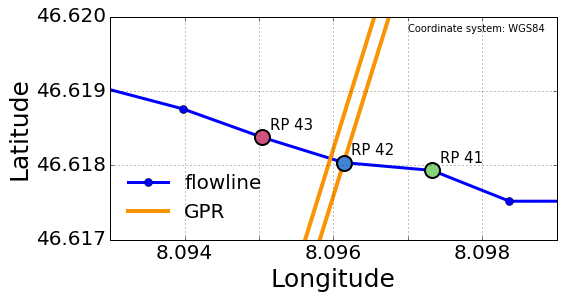

In [80]:
color_caves = ['k', 'r', 'b', 'g', 'y']

plt.figure(figsize=[8,8])

plt.plot(lon, lat, linestyle='-', marker='o', lw=3, markersize='8', label='flowline')
#plt.plot(lon_ref, lat_ref, marker='x', linestyle='none', label=caves[i],
#             color='#F89406', markersize=10, markeredgewidth=3)

ylim = np.array([46.617,46.620])

ax = plt.gca()

ax.set_xticks(np.arange(8.094, 8.099, 0.001))
ax.set_xticklabels(['8.094','','8.096','','8.098'])
ax.set_xlabel('Longitude')

ax.set_yticks(np.arange(46.616,  46.6201, 0.001))
ax.set_yticklabels(['46.616','46.617','46.618','46.619','46.620'])
ax.set_ylabel('Latitude')

ax.set_xlim(8.093, 8.099)
ax.set_ylim(ylim)

plt.text(8.097, 46.6198, 'Coordinate system: WGS84')

ax.set_aspect('equal')

a = 8.092 + 0.003
b = 8.092 + 0.005

l_ = ['', 'GPR']

for i in [-2, -1]:
    x = np.array([a,b])
    y = k_s[i]*x + d_s[i]
    ax.plot(x,y, lw=4, color='#F89406', label=l_[i])

marker = ['o','o','o']
color_rp = ['#87D37C', '#4183D7', '#D2527F']
text_rp = ['RP 41', 'RP 42', 'RP 43']
    
for i, i_rp in enumerate(indices):
    x_ = lon[i_rp]
    y_ = lat[i_rp]
    d_ = 0.0001
    plt.plot(x_, y_, marker=marker[i], linestyle='none',
             color=color_rp[i], markersize=15, markeredgewidth=2)
    plt.text(x_+d_,y_+d_, text_rp[i], fontsize=15)

plt.grid()
plt.legend(loc=3, numpoints=1, frameon=False)

In [ ]:
color_caves = ['k', 'r', 'b', 'g', 'y']

plt.figure(figsize=[10,10])

plt.plot(lon, lat, linestyle='-', marker='o', lw=1, markersize='2', label='flowline', color='b')

for i in range(0, n_caves):
    plt.plot(lon_caves[i], lat_caves[i], marker='x', linestyle='none', label=caves[i],
             color=color_caves[i], markersize=15, markeredgewidth=3)

#plt.plot(lon, lat, linestyle='-', marker='o', lw=3, markersize='8', label='flowline')
#plt.plot(lon_ref, lat_ref, marker='x', linestyle='none', label=caves[i],
#             color='#F89406', markersize=10, markeredgewidth=3)

ylim = np.array([46.617,46.620])

ax = plt.gca()

#ax.set_xticks(np.arange(8.094, 8.099, 0.001))
#ax.set_xticklabels(['8.094','','8.096','','8.098'])
ax.set_xlabel('Longitude')

#ax.set_yticks(np.arange(46.616,  46.6201, 0.001))
#ax.set_yticklabels(['46.616','46.617','46.618','46.619','46.620'])
ax.set_ylabel('Latitude')

#ax.set_xlim(8.093, 8.099)
#ax.set_ylim(ylim)

plt.text(8.097, 46.6198, 'Coordinate system: WGS84')

ax.set_aspect('equal')

a = 8.092 + 0.003
b = 8.092 + 0.005

l_ = ['', 'GPR']

for i in [-2, -1]:
    x = np.array([a,b])
    y = k_s[i]*x + d_s[i]
    ax.plot(x,y, lw=4, color='#F89406', label=l_[i])

marker = ['o','o','o']
color_rp = ['#87D37C', '#4183D7', '#D2527F']
text_rp = ['RP 41', 'RP 42', 'RP 43']
    
for i, i_rp in enumerate(indices):
    x_ = lon[i_rp]
    y_ = lat[i_rp]
    d_ = 0.0001
    plt.plot(x_, y_, marker=marker[i], linestyle='none',
             color=color_rp[i], markersize=20, markeredgewidth=2)
    plt.text(x_+d_,y_+d_, text_rp[i], fontsize=15)

plt.grid()
plt.legend(loc=3, numpoints=1, frameon=False)

In [103]:
n_caves = 5
caves = ['E1', 'E2: BL-1840', 'E3: BL-1750', 'E5', 'E4: BL-1650', 'GPR Ref 1', 'GPR Ref 2']
lat_caves = np.array([46.624071981, 46.618130279, 46.618768249, 46.619290335, 46.619587094, lat_ref[0], lat_ref[1]])
lon_caves = np.array([8.084296603, 8.089826384, 8.089951579, 8.089892598, 8.089909233, lon_ref[0], lon_ref[1]])
h_caves = np.array([1601, 1885, 1794, 1740, 1697])
h_caves_rel = np.array([np.nan, 188, 97, 43, 0])
n = 0

In [104]:
inds = ([54,55],[46,47],[47,48],[47,48],[47,48], [42,43], [42,43])
f_s = np.zeros(n_caves+n)
k_s = np.zeros(n_caves+n)
d_s = np.zeros(n_caves+n)
points_i = list()

for i in range(0,n_caves+n):
    print('-----------------------------------------------------------------')
    print(caves[i])
    l_x = lon[inds[i]]
    l_y = lat[inds[i]]

    p_x = lon_caves[i]
    p_y = lat_caves[i]
    
    # calc linear equation through points
    k = (l_y[-1]-l_y[0])/(l_x[-1]-l_x[0])
    d = l_y[0] - k *l_x[0]
    print('g: y = {}x + {}'.format(k,d))

    # calc linear equation through points
    k_ = -1/k
    d_ = p_y - k_*p_x
    k_s[i] = k_
    d_s[i] = d_
    print('f: y = {}x + {}'.format(k_,d_))

    # calc x and y of intersection

    x_i = (d-d_)/(k_-k)
    y_i = k*x_i + d
    points_i.append([x_i,y_i])
    print('The lines intersect at P({},{})'.format(x_i,y_i))

    l_ = np.sqrt((l_x[0]-x_i)**2 + (l_y[0]-y_i)**2)
    l = np.sqrt((l_x[0]-l_x[1])**2 + (l_y[0]-l_y[1])**2)

    f = l_/l
    f_s[i] = f
    print('Distance {}, equals {} times l = {}'.format(round(l_,5), round(f,3), round(l,5)))
    print('-----------------------------------------------------------------')

-----------------------------------------------------------------
E1
g: y = -1.0017110367424882x + 54.72364658933144
f: y = 0.9982918859034913x + 38.55358427898794
The lines intersect at P(8.085019340347113,46.624793483829265)
Distance 0.00064, equals 0.666 times l = 0.00096
-----------------------------------------------------------------
-----------------------------------------------------------------
E2: BL-1840
g: y = -0.6885323174327699x + 52.19083483110271
f: y = 1.4523646525824006x + 34.8687523933499
The lines intersect at P(8.09103972790903,46.6198924968049)
Distance 0.00088, equals 0.849 times l = 0.00103
-----------------------------------------------------------------
-----------------------------------------------------------------
E3: BL-1750
g: y = -0.6885099757064559x + 52.19065406616768
f: y = 1.452411780924358x + 34.86882726855279
The lines intersect at P(8.09082664696462,46.62003920802093)
Distance 0.0001, equals 0.1 times l = 0.00103
--------------------------------

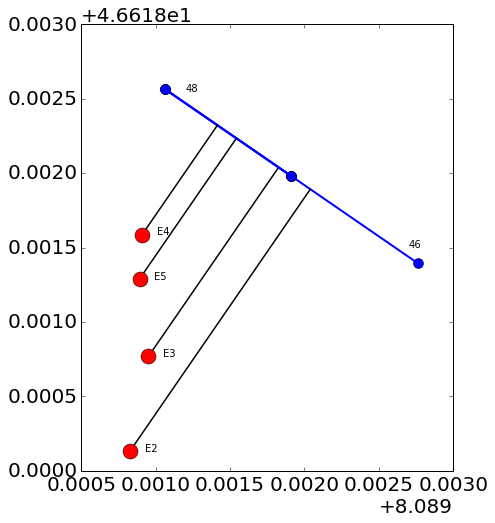

In [105]:
plt.figure(figsize=[8,8])
for i in range(1, n_caves+n):
    l_x = lon[inds[i]]
    l_y = lat[inds[i]]

    p_x = lon_caves[i]
    p_y = lat_caves[i]
    plt.plot(l_x, l_y, 'o-', markersize=10, color='b', lw=2)
    
    x = np.array([p_x,points_i[i][0]])
    y = k_s[i]*x + d_s[i]
    plt.plot(x,y, 'k')
    
    plt.plot(p_x, p_y, marker='o', color='r', markersize=15)

    plt.text(p_x+0.0001, p_y, caves[i][:2])
    
plt.text(8.0917,46.6195, '46')
plt.text(8.0902,46.62055, '48')
         
plt.gca().set_aspect('equal')

In [134]:
cave_ind = np.arange(46, 48+1)
cave_ind

array([46, 47, 48])

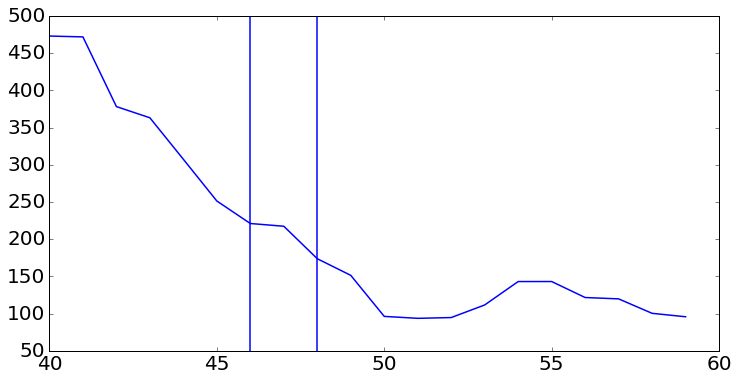

In [107]:
# Plot of the width around the closest point
width_meter = u_fl.widths_m
plt.plot(np.arange(40,60), width_meter[40:60])
plt.axvline(cave_ind[0])
plt.axvline(cave_ind[-1])

In [108]:
mod_fl= model.fls[0]

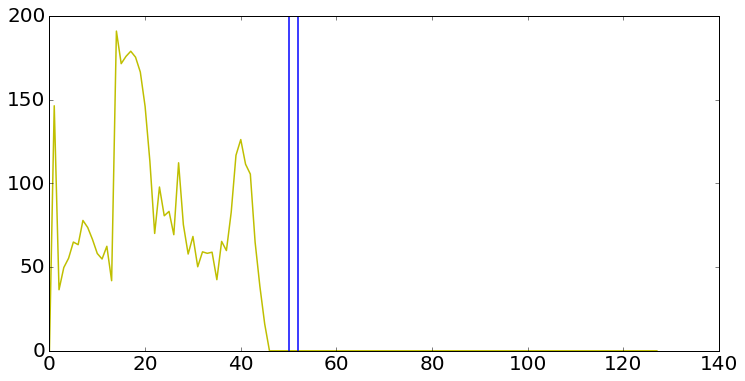

In [109]:
plt.plot(mod_fl.surface_h-mod_fl.bed_h, color='y')
plt.axvline(index_cave-1)
plt.axvline(index_cave+1)

In [147]:
d_year = 1
y1 = 2015
years_height = np.arange(y0, y1+1, d_year)
years_height

array([1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
       1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900,
       1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

In [148]:
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=y_start, 
                                fs=0., glen_a=glen_a)
# create container
height_cave = list()
surf_h = list()
widths = list()

for i, y in enumerate(years_height):
    model.run_until(y)
    fl = model.fls[0]
    surf_h.append(fl.surface_h)
    widths.append(fl.widths_m)
    heights = fl.surface_h
    height_cave.append(heights[cave_ind])

In [150]:
height_cave_ref = h_caves[1:]
bed_h = u_fl.bed_h

[array([ 1825.82859675,  1788.73916728,  1752.06119598]),
 array([ 1817.21474585,  1778.33010271,  1740.79776709]),
 array([ 1807.0151163 ,  1765.51030001,  1727.24519258]),
 array([ 1820.21160078,  1755.49384535,  1726.79371705]),
 array([ 1859.95688055,  1769.61872791,  1726.79371705]),
 array([ 1874.80806195,  1829.92388273,  1735.8179117 ]),
 array([ 1887.49260577,  1849.55573674,  1806.19274548]),
 array([ 1896.84138318,  1862.41116007,  1825.66981166]),
 array([ 1905.14630602,  1873.07005456,  1840.15838408]),
 array([ 1911.33491703,  1880.55124282,  1849.3552604 ]),
 array([ 1917.44143687,  1887.47752947,  1857.25429698]),
 array([ 1920.55848559,  1890.97649439,  1861.20062912]),
 array([ 1923.21242861,  1893.80505024,  1864.27633477]),
 array([ 1926.24556964,  1896.99589126,  1867.66432861]),
 array([ 1927.77423186,  1898.62431263,  1869.41565908]),
 array([ 1927.72670803,  1898.58774352,  1869.39560897]),
 array([ 1928.05229958,  1898.96723177,  1869.8357815 ]),
 array([ 1927.

In [151]:
h_gp = dict()
for i in range(0, cave_ind.size):
    h_gp[str(cave_ind[i])] = [row[i] for row in height_cave]

In [172]:
h_mes = np.array([1879,1795,1760, 1740, 1710, 1690, 1670, 1640])
h_mes_y = np.array([2000, 2005, 2008, 2010, 2011, 2012, 2013, 2015])
h_mes_err = np.array([20,5,10,5,10,5,10,20])

In [407]:
h_caves_time = list()
for i in range(1, n_caves):
    a = inds[i][0]
    h_a = np.array(h_gp[str(a)])
    b = inds[i][1]
    h_b = np.array(h_gp[str(b)])
    h_ = (h_a*(1-f_s[i])) + (h_b*(f_s[i]))
    h_caves_time.append(h_)

In [408]:
h_bed_interp = list()
for i in range(1, n_caves):
    a = inds[i][0]
    h_a = np.array(bed_h[a])
    b = inds[i][1]
    h_b = np.array(bed_h[b])
    h_ = (h_a*(1-f_s[i])) + (h_b*(f_s[i]))
    h_bed_interp.append(h_)

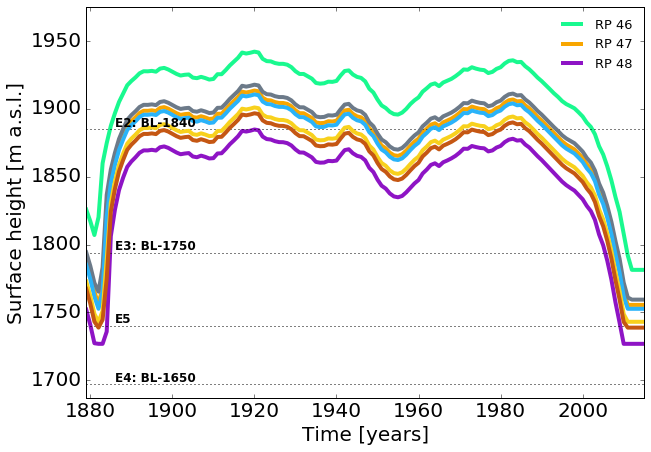

In [410]:
fig = plt.figure(figsize=[10,7])
for i in range(0, cave_ind.size):
    h_grid_point = [row[i] for row in height_cave]
    plt.plot(years_height, h_grid_point, label='RP {}'.format(cave_ind[i]), color=color_cave[i], lw=4)

ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(1886, h_+2, caves[i+1], fontsize=12, fontweight='bold')
    
for i in range(0, n_caves-1):
    plt.plot(years_height, h_caves_time[i], lw=4, color=color_caves[i])
    
ax.set_xlim([y0, y1])
ax.set_ylim([height_cave_ref[-1]-10, 1975])

ax.legend(hand, lab, loc=0, ncol=1, fontsize=13)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Surface height [m a.s.l.]')

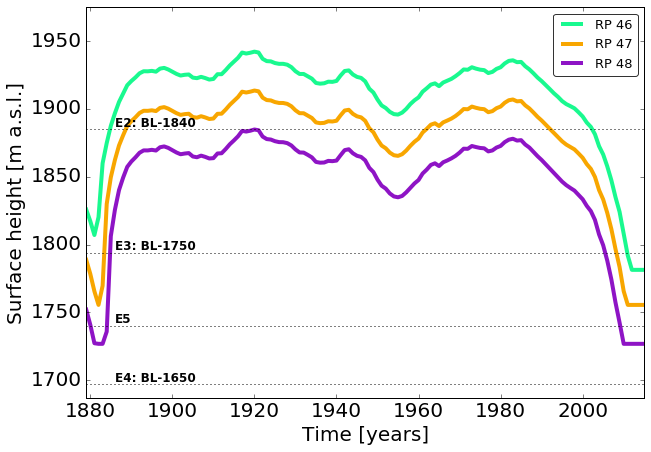

In [411]:
fig = plt.figure(figsize=[10,7])
for i in range(0, cave_ind.size):
    h_grid_point = [row[i] for row in height_cave]
    plt.plot(years_height, h_grid_point, label='RP {}'.format(cave_ind[i]), color=color_cave[i], lw=4)

ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(1886, h_+2, caves[i+1], fontsize=12, fontweight='bold')

ax.set_xlim([y0, y1])
ax.set_ylim([height_cave_ref[-1]-10, 1975])

leg = ax.legend(hand, lab, loc=0, ncol=1, fontsize=13, frameon=True, fancybox=True)
leg.get_frame().set_alpha(0.8)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Surface height [m a.s.l.]')

In [242]:
k_, d_, r_, p_, std_err_ = stats.linregress(h_mes_y, h_mes)

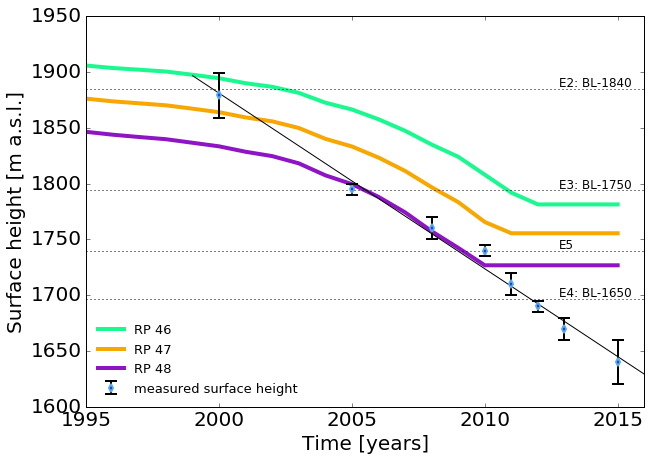

In [245]:
fig = plt.figure(figsize=[10,7])
for i in range(0, cave_ind.size):
    h_grid_point = [row[i] for row in height_cave]
    plt.plot(years_height, h_grid_point, label='RP {}'.format(cave_ind[i]), color=color_cave[i], lw=4)

ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(2012.8, h_+2, caves[i+1], fontsize=12, fontweight='normal')

ax.set_xlim([1995, y1+1])
#ax.set_ylim([height_cave_ref[-1]-10, 1975])


c_ = '#59ABE3'
plt.errorbar(h_mes_y, h_mes, yerr=h_mes_err, zorder=100, label='measured surface height',
             ecolor='k', elinewidth=2, barsabove=True, capsize=6,
             linestyle='none', marker='d', markersize='5', markeredgecolor=c_, markeredgewidth=2, fillstyle='full')

x_lin = np.array([1999, 2016])
h_lin = x_lin*k_ + d_
plt.plot(x_lin, h_lin, lw=1, c='k')

ax.legend(loc=3, ncol=1, fontsize=13, numpoints=1)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Surface height [m a.s.l.]')

In [247]:
k_, d_, r_, p_, std_err_ = stats.linregress(h_mes_y, h_mes_)

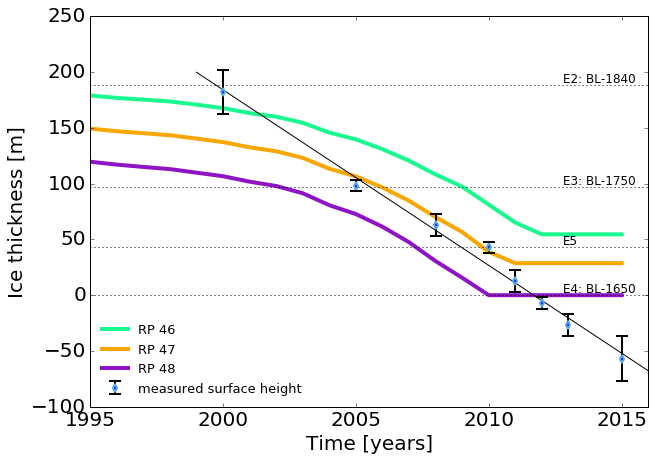

In [251]:
fig = plt.figure(figsize=[10,7])
for i in range(0, cave_ind.size):
    h_grid_point = [row[i] for row in height_cave]
    plt.plot(years_height, h_grid_point-bed_h[cave_ind[-1]], label='RP {}'.format(cave_ind[i]),
             color=color_cave[i], lw=4)

ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    h_ = h_-height_cave_ref[-1]
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(2012.8, h_+2.5, caves[i+1], fontsize=12, fontweight='normal')

ax.set_xlim([1995, y1+1])
#ax.set_ylim([height_cave_ref[-1]-10, 1975])


c_ = '#59ABE3'
h_mes_ = h_mes - height_cave_ref[-1]
plt.errorbar(h_mes_y, h_mes_, yerr=h_mes_err, zorder=100, label='measured surface height',
             ecolor='k', elinewidth=2, barsabove=True, capsize=6,
             linestyle='none', marker='d', markersize='5', markeredgecolor=c_, markeredgewidth=2, fillstyle='full')

x_lin = np.array([1999, 2016])
h_lin = x_lin*k_ + d_
plt.plot(x_lin, h_lin, lw=1, c='k')

ax.legend(loc=3, ncol=1, fontsize=13, numpoints=1)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Ice thickness [m]')

['#6C7A89', '#2AB3F9', '#F8D11D', '#C55713', '#66AB13']

In [342]:
height_cave_ref

array([1885, 1794, 1740, 1697])

In [350]:
h_bed_interp

[1759.387206507743, 1752.6217247397676, 1743.0367031062997, 1738.7374748588204]

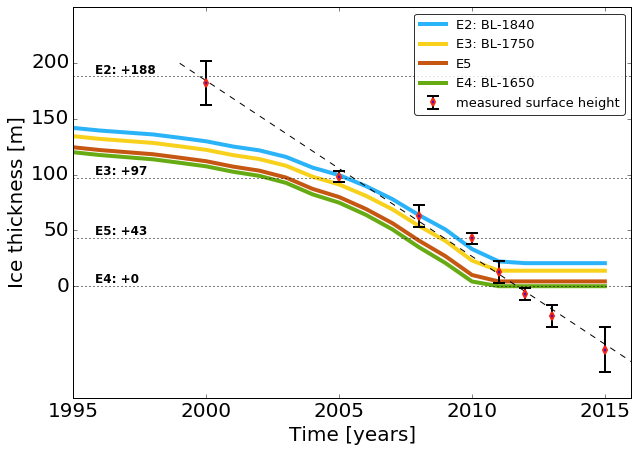

In [491]:
fig = plt.figure(figsize=[10,7])

for i in range(0, n_caves-1):
    plt.plot(years_height, h_caves_time[i]-h_bed_interp[-1], lw=4, color=color_caves[i+1], label=caves[i+1])    

ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    h_ = h_-height_cave_ref[-1]
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(1995.8, h_+2.5, '{}: +{}'.format(caves[i+1][:2], int(h_)), fontsize=12, fontweight='bold')

ax.set_yticks(np.arange(0,201,50))
    
ax.set_xlim([1995, y1+1])
ax.set_ylim([-100,250])


c_ = '#F22613'
h_mes_ = h_mes - height_cave_ref[-1]
plt.errorbar(h_mes_y, h_mes_, yerr=h_mes_err, zorder=100, label='measured surface height',
             ecolor='k', elinewidth=2, barsabove=True, capsize=6,
             linestyle='none', marker='d', markersize='5', markeredgecolor=c_, markeredgewidth=2, fillstyle='full')

x_lin = np.array([1999, 2016])
h_lin = x_lin*k_ + d_
plt.plot(x_lin, h_lin, lw=1, c='k', ls='--')

leg = ax.legend(loc=1, ncol=1, fontsize=13, numpoints=1, frameon=True, fancybox=True)
leg.get_frame().set_alpha(0.8)

ax.set_xlabel('Time [years]')
ax.set_ylabel('Ice thickness [m]')

for y_0 in year_o[1:]:
    #ax.axvline(y_0)
    a

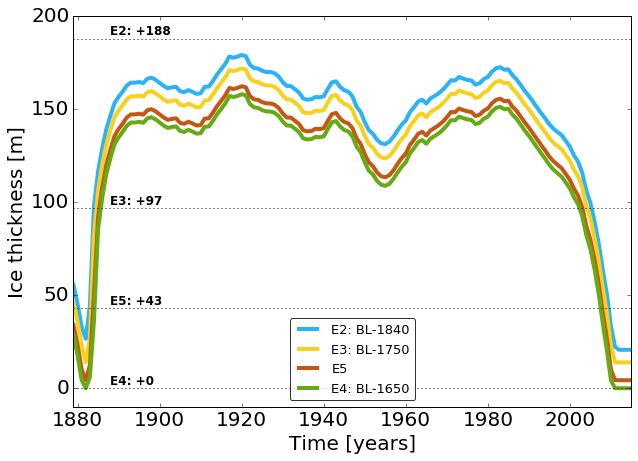

In [487]:
fig = plt.figure(figsize=[10,7])
#for i in range(0, cave_ind.size):
#    h_grid_point = [row[i] for row in height_cave]
#    plt.plot(years_height, h_grid_point-bed_h[cave_ind[-1]], label='RP {}'.format(cave_ind[i]),
#             color=color_cave[i], lw=4)

for i in range(0, n_caves-1):
    plt.plot(years_height, h_caves_time[i]-h_bed_interp[-1], lw=4, color=color_caves[i+1], label=caves[i+1])    
    
ax = plt.gca()
hand, lab = ax.get_legend_handles_labels()

for i, h_ in enumerate(height_cave_ref):
    h_ = h_-height_cave_ref[-1]
    plt.axhline(h_, color='k', linestyle=':', lw=1)
    plt.text(1888, h_+2, '{}: +{}'.format(caves[i+1][:2], int(h_)), fontsize=12, fontweight='bold')

ax.set_xlim([y0, y1])
ax.set_ylim([-10, 200])

leg = ax.legend(hand, lab, loc=8, ncol=1, fontsize=13, frameon=True, fancybox=True)
leg.get_frame().set_alpha(0.8)
ax.set_xlabel('Time [years]')
ax.set_ylabel('Ice thickness [m]') 

In [489]:
k_

-15.730886850152904

In [488]:
year_o

array([ 1899.,  2004.,  2008.,  2011.])

In [475]:
years_height

array([1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
       1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900,
       1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955,
       1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

In [482]:
year_o = np.zeros(4)
tmp = list()
treshold = 3
for i in range(0,n_caves-1):
    a = h_caves_time[i] - h_bed_interp[-1] - h_caves_rel[i+1]
    ind_o = np.where(a[20:] < treshold)[0][0]
    y__ = years_height[20:]
    year_o[i] = y__[ind_o]

In [483]:
year_o

array([ 1899.,  2004.,  2008.,  2011.])

In [117]:
# modify plot properties
label_size = 20

matplotlib.rc('axes', labelsize=label_size)
matplotlib.rc('xtick', labelsize=label_size) 
matplotlib.rc('ytick', labelsize=label_size)

matplotlib.rc('legend', fontsize=15)
matplotlib.rc('legend', frameon=False)

In [124]:
if(len(inds) != 5):
    inds = inds[:-2]

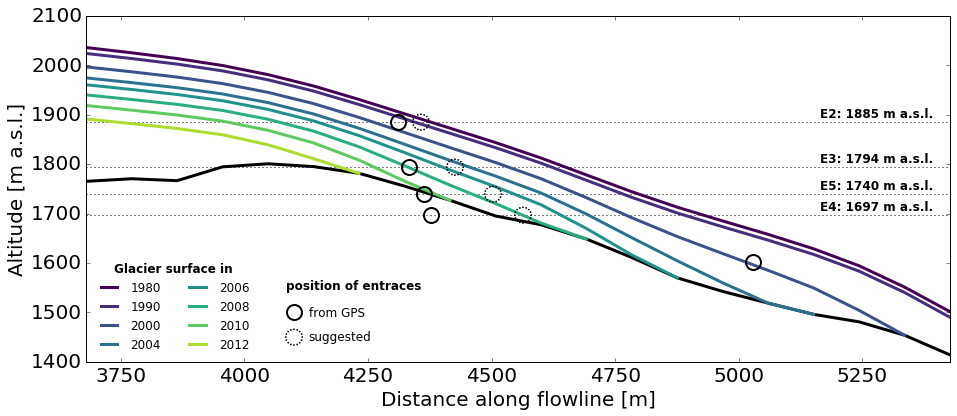

In [370]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,2])

x_t = 5165
for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        ax.axhline(h_, color='k', linestyle=':', lw=1)
        ax.text(x_t, h_+10, '{}: {} m a.s.l.'.format(caves[i+1][:2], int(h_)), fontsize=12, fontweight='bold')

ind=np.arange(40,60)
x = ind*u_fl.map_dx*u_fl.dx
years_plot = np.array([1980, 1990, 2000, 2004, 2006, 2008, 2010, 2012])


col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=years_plot.size)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

# plot bedrock
bed_h_ = bed_h[ind]
ax.plot(x, bed_h_, color='k', lw=3)

c_count = 0
for i,y in enumerate(years_height):
    if y in years_plot:
        col = scalarMap.to_rgba(c_count)
        c_count += 1
        surf_h_ = surf_h[i][ind]
        ind_terminus = np.where(bed_h_ == surf_h_)[0]
        if ind_terminus.any():
            surf_h_[ind_terminus[0]+1:] = np.nan
        ax.plot(x, surf_h_, color=col, label=y, lw=3)

l_title = 'Glacier surface in'
leg_1 = ax.legend(loc=3, ncol=2, title=l_title, fontsize=12, frameon=False)
leg_1.get_title().set_fontsize(12)
leg_1.get_title().set_fontweight('bold')

m_ = u'\u25CC'
x_caves = (f_s + [x[0] for x in inds] + [0,0.5,1,1.5,2])*u_fl.map_dx*u_fl.dx
for i in range(1,n_caves):
    ax.text(x_caves[i], h_caves[i], m_, fontsize=37, fontname='Arial', va='center', ha='center', 
            color='0', weight='bold')

x_caves = (f_s + [x[0] for x in inds])*u_fl.map_dx*u_fl.dx
plt.plot(x_caves, h_caves, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)

# costume legend for caves
x_hand = 4100
y_hand = 1500
d_y_leg = 50
d_x_leg = 30

ax.plot(x_hand, y_hand, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)
ax.text(x_hand+d_x_leg, y_hand, 'from GPS', fontsize=12, va='center')
ax.text(x_hand-1, y_hand-d_y_leg, m_, fontsize=37, fontname='Arial', va='center', ha='center', 
            color='0', weight='bold')
ax.text(x_hand+d_x_leg, y_hand-d_y_leg, 'suggested', fontsize=12, va='center')
# legend title
ax.text(x_hand-15, y_hand+d_y_leg+5, 'position of entraces', fontsize=12, va='center', weight='bold')



ax.set_xticks(np.arange(3000,6000,250))
ax.set_xlim([x[0], x[-1]])
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('Distance along flowline [m]')
ax.set_ylabel('Altitude [m a.s.l.]')

In [126]:
inds

([54, 55], [46, 47], [47, 48], [47, 48], [47, 48])

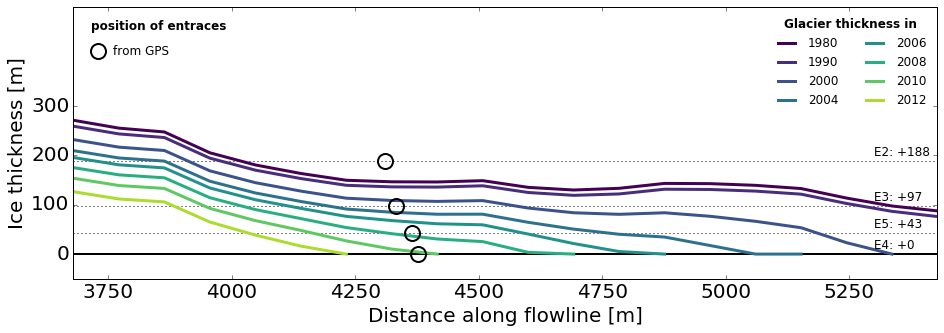

In [268]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,2])

x_t = 5300
for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        h_ = h_-height_cave_ref[-1]
        ax.axhline(h_, color='k', linestyle=':', lw=1)

ind=np.arange(40,60)
x = ind*u_fl.map_dx*u_fl.dx
years_plot = np.array([1980, 1990, 2000, 2004, 2006, 2008, 2010, 2012])


col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=years_plot.size)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

# plot bedrock
bed_h_ = bed_h[ind]
ax.axhline(0, color='k', lw=2)

c_count = 0
for i,y in enumerate(years_height):
    if y in years_plot:
        col = scalarMap.to_rgba(c_count)
        c_count += 1
        thick_ = surf_h[i][ind] - bed_h_
        ind_terminus = np.where(thick_ == 0)[0]
        if ind_terminus.any():
            thick_[ind_terminus[0]+1:] = np.nan
        ax.plot(x, thick_, color=col, label=y, lw=3)

for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        h_ = h_-height_cave_ref[-1]
        ax.text(x_t, h_+10, '{}: +{}'.format(caves[i+1][:2], int(h_)), fontsize=12)

        
    
l_title = 'Glacier thickness in'
leg_1 = ax.legend(loc=1, ncol=2, title=l_title, fontsize=12, frameon=False)
leg_1.get_title().set_fontsize(12)
leg_1.get_title().set_fontweight('bold')

m_ = u'\u25CC'
x_caves = (f_s + [x[0] for x in inds] + [0,0.5,1,1.5,2])*u_fl.map_dx*u_fl.dx

x_caves = (f_s + [x[0] for x in inds])*u_fl.map_dx*u_fl.dx
plt.plot(x_caves[1:], h_caves[1:]-h_caves[-1], linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)

# costume legend for caves
x_hand = 3730
y_hand = 410
d_y_leg = 50
d_x_leg = 30

ax.plot(x_hand, y_hand, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)
ax.text(x_hand+d_x_leg, y_hand, 'from GPS', fontsize=12, va='center')
#ax.text(x_hand-1, y_hand-d_y_leg, m_, fontsize=37, fontname='Arial', va='center', ha='center', 
#            color='0', weight='bold')
#ax.text(x_hand+d_x_leg, y_hand-d_y_leg, 'suggested', fontsize=12, va='center')
# legend title
ax.text(x_hand-15, y_hand+d_y_leg, 'position of entraces', fontsize=12, va='center', weight='bold')

ax.set_xticks(np.arange(3000,6000,250))
ax.set_yticks(np.arange(0,301,100))
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([-50,500])
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('Distance along flowline [m]')
ax.set_ylabel('Ice thickness [m]')

array([8])

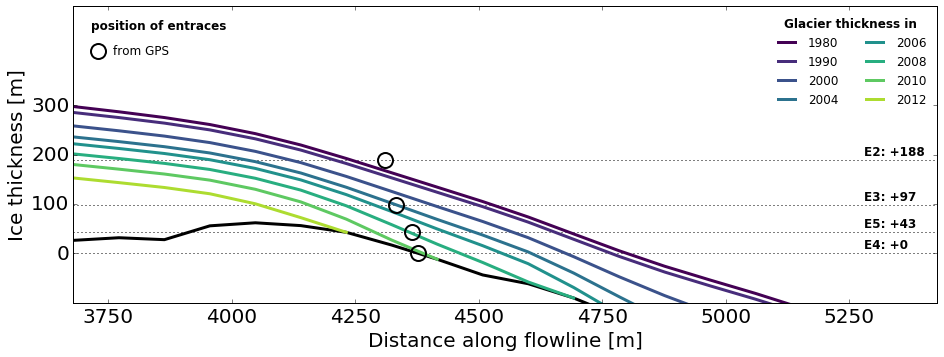

In [378]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,2])

x_t = 5280

for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        h_ = h_-height_cave_ref[-1]
        ax.axhline(h_, color='k', linestyle=':', lw=1)

ind=np.arange(40,60)
x = ind*u_fl.map_dx*u_fl.dx
years_plot = np.array([1980, 1990, 2000, 2004, 2006, 2008, 2010, 2012])


col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=years_plot.size)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

# plot bedrock

bed_h_ = bed_h[ind] - h_bed_interp[-1]
ax.plot(x, bed_h_, color='k', lw=3)

c_count = 0
for i,y in enumerate(years_height):
    if y in years_plot:
        col = scalarMap.to_rgba(c_count)
        c_count += 1
        thick_ = surf_h[i][ind] - h_bed_interp[-1]
        ind_terminus = np.where(thick_ == bed_h_)[0]
        if ind_terminus.any():
            thick_[ind_terminus[0]+1:] = np.nan
        ax.plot(x, thick_, color=col, label=y, lw=3)

for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        h_ = h_-height_cave_ref[-1]
        ax.text(x_t, h_+10, '{}: +{}'.format(caves[i+1][:2], int(h_)), fontsize=12, fontweight='bold')


l_title = 'Glacier thickness in'
leg_1 = ax.legend(loc=1, ncol=2, title=l_title, fontsize=12, frameon=False)
leg_1.get_title().set_fontsize(12)
leg_1.get_title().set_fontweight('bold')

m_ = u'\u25CC'
x_caves = (f_s + [x[0] for x in inds] + [0,0.5,1,1.5,2])*u_fl.map_dx*u_fl.dx

x_caves = (f_s + [x[0] for x in inds])*u_fl.map_dx*u_fl.dx
plt.plot(x_caves[1:], h_caves[1:]-h_caves[-1], linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)


# costume legend for caves
x_hand = 3730
y_hand = 410
d_y_leg = 50
d_x_leg = 30

ax.plot(x_hand, y_hand, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)
ax.text(x_hand+d_x_leg, y_hand, 'from GPS', fontsize=12, va='center')
#ax.text(x_hand-1, y_hand-d_y_leg, m_, fontsize=37, fontname='Arial', va='center', ha='center', 
#            color='0', weight='bold')
#ax.text(x_hand+d_x_leg, y_hand-d_y_leg, 'suggested', fontsize=12, va='center')
# legend title
ax.text(x_hand-15, y_hand+d_y_leg, 'position of entraces', fontsize=12, va='center', weight='bold')

ax.set_xticks(np.arange(3000,6000,250))
ax.set_yticks(np.arange(0,301,100))
ax.set_xlim([x[0], x[-1]])
ax.set_ylim([-100,500])
  

ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('Distance along flowline [m]')
ax.set_ylabel('Ice thickness [m]')

In [289]:
print(height_cave_ref)
print(cave_ind)

[1885 1794 1740 1697]
[46 47 48]


In [387]:
a = model.fls[-1]
w = a.widths_m
h = a.surface_h - a.bed_h
r = w/h

In [396]:
np.where(r <= 5)

(array([ 1, 27, 32, 33, 34, 36, 39, 40, 41, 42]),)

In [330]:
a = np.arange(0,1, 0.1)
b = np.random.rand(10)

In [358]:
print('{}'.format(u'\u25CC'))

◌


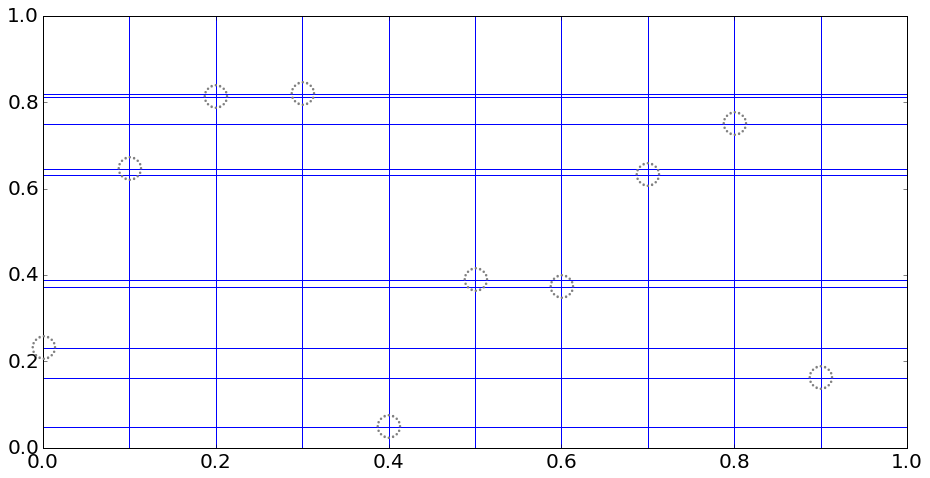

In [338]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for i in range(0,10):
    ax.text(a[i], b[i], u'\u25CC', fontsize=50, fontname='Arial', va='center', ha='center', color='0.5')
    ax.axhline(b[i])
    ax.axvline(a[i])

### Delete Climate File

In [516]:
# set gdir
bdir = '/Users/oberrauch/bac/raw_data/grindelwald/'
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)
# filepaths
climate_file_path = gdir.get_filepath('climate_monthly')
original_file_path = climate_file_path.replace('climate_monthly.nc', 'climate_monthly_orig.nc')
climate_dir_path = os.path.dirname(climate_file_path)

if os.path.exists(original_file_path):
    # delete modified file
    os.remove(climate_file_path)
    # rename original file
    os.rename(original_file_path, climate_file_path)
    print('Original filed restored...')
else:
    print('No modified file to delete...')

Original filed restored...


In [524]:
a = 2
print('{:03d}'.format(a))
print(str(a).zfill(3))

002
002


In [535]:
text_ = '\subfigure{\includegraphics[width=0.23\\textwidth]{images/appendix/appendix_'
print(text_)

\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_


In [542]:
for i in range(1,497):
    if not np.mod(i-1, 32):
        print('\end{figure}')
        print('\\begin{figure}[p!]')
        print('\centering')
    print(text_ + '{:03d}'.format(i) + '}}')


\end{figure}
\begin{figure}[p!]
\centering
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_001}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_002}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_003}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_004}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_005}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_006}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_007}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_008}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_009}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_010}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/appendix_011}}
\subfigure{\includegraphics[width=0.23\textwidth]{images/appendix/

In [530]:
print(text + '}}')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

### Length data

In [543]:
lengths_data = pd.read_csv(utils.get_demo_file('grindelwald_lengths_all.csv'), index_col=0)

In [5]:
n_l = lengths_data.size
l_ = np.zeros(n_l)

In [6]:
ind_1880 = np.where(lengths_data.index == 1880)[0][0]
l_[ind_1880] = -1

In [7]:
for i in np.arange(ind_1880+1, n_l):
    l_[i] = lengths_data.dl.iloc[i] - lengths_data.dl.iloc[i-1]

In [8]:
ind_rest = np.arange(1,ind_1880)[::-1]
for i in ind_rest:
    l_[i] = lengths_data.dl.iloc[i] - lengths_data.dl.iloc[i-1]

In [9]:
lengths_data.l = pd.Series(l_, index=lengths_data.index)

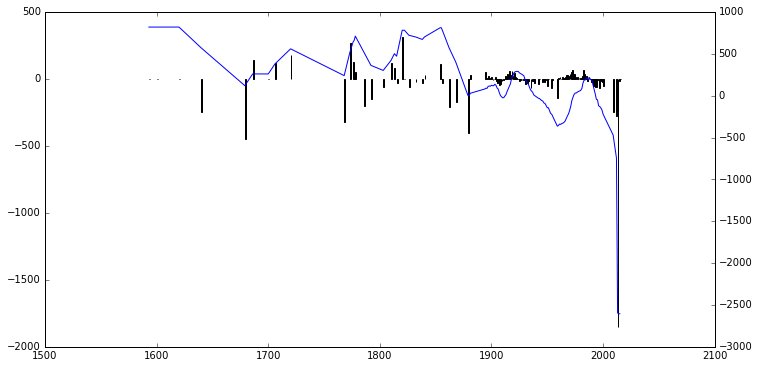

In [11]:
years = lengths_data.index
plt.bar(years, l_)
ax = plt.gca().twinx()
ax.plot(lengths_data.dl)

In [52]:
# modify plot properties
matplotlib.rc('lines', linewidth=3)

matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

matplotlib.rc('legend', fontsize=15)
matplotlib.rc('legend', frameon=False)

In [53]:
years = lengths_data.index
years_ = np.insert(years, 0, years[0]-1)
years_dif = years_[1:] - years_[:-1]
years_mid = years_[:-1] + years_dif/2

In [54]:
l_pos_ind = np.where(l_ > 0)
l_0_ind = np.where(l_ == 0)
l_neg_ind = np.where(l_ < 0)

NameError: name 'l_' is not defined

In [15]:
max_width = 20
bar_width = years_dif
years_mid_pos = years_mid - bar_width/2
#bar_width = np.clip(bar_width, 0, max_width)

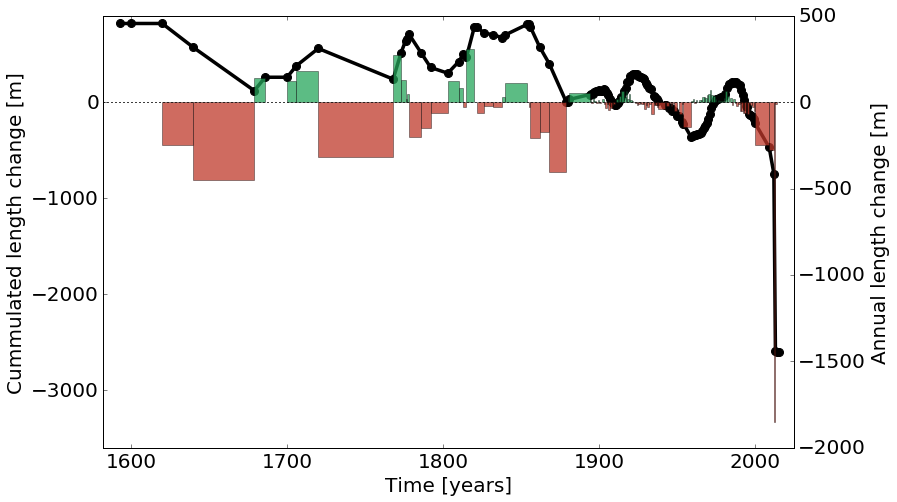

In [16]:
fig = plt.figure()
ax_ = fig.add_axes([0,0,0.8,1])

x_lim = [years_[0]-10,years_[-1]+10]
y_lim = [-3600,3600*0.25]

ax_.axhline(0, lw=1, color='k', linestyle=':', label='length in the year 1879 as reference')
ax_.plot(lengths_data.dl, color='k', label='cumulated lenght change in relation to 1879',
         lw=3.5, alpha=1, marker='o', markersize=8, markeredgecolor='k', markeredgewidth=1, fillstyle='full')
ax_.set_xlim(x_lim)
ax_.set_ylim(y_lim)
h_ax_, l_ax_ = ax_.get_legend_handles_labels()

ax_.set_xlabel('Time [years]')
ax_.set_ylabel('Cummulated length change [m]')

a_ = 0.75
ax = plt.gca().twinx()

ax.bar(years_mid_pos[l_pos_ind], l_[l_pos_ind], bar_width[l_pos_ind],
       color='#26A65B', alpha=a_, lw=0.5, label='positive annual lenght change (right)')
ax.bar(years_mid_pos[l_neg_ind], l_[l_neg_ind], bar_width[l_neg_ind],
       color='#C0392B', alpha=a_, lw=0.5, label='negative annual lenght change (right)')
ax.set_xlim(x_lim)
ax.axhline(0, lw=1, color='k', linestyle=':')

ax.set_ylabel('Annual length change [m]')

h_ax, l_ax = ax.get_legend_handles_labels()
handle = np.concatenate((h_ax_, h_ax), 0)
label = np.concatenate((l_ax_, l_ax), 0)
#ax.legend(handle, label, numpoints=1, loc=3)

NameError: name 'years_' is not defined

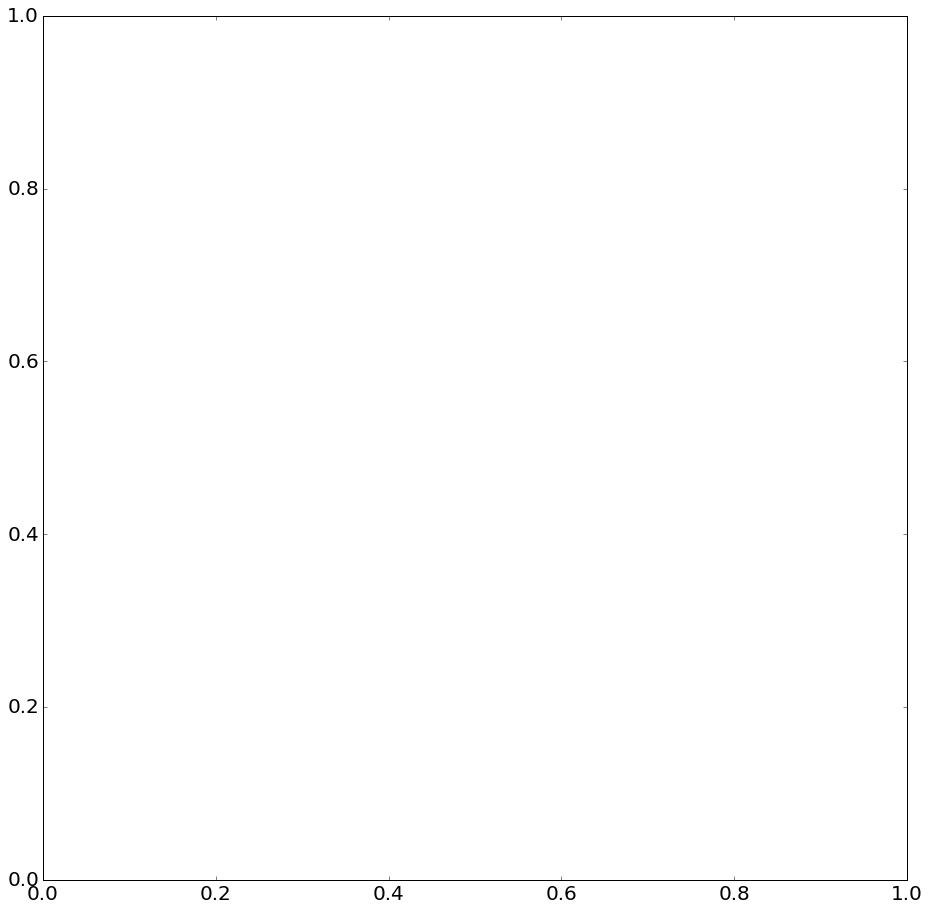

In [544]:
from matplotlib import patches
c1 = '#25B247'
c2 = '#B2000E'

matplotlib.rc('axes', labelsize=20)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

matplotlib.rc('legend', fontsize=20)
matplotlib.rc('legend', frameon=True)

fig = plt.figure(figsize=(12,12))
ax_ = fig.add_axes([0,0,1,1])

x_lim = [years_[0]-10,years_[-1]+10]
y_lim = [-3600,3600*0.25]

ax_.axhline(0, lw=1, color='k', linestyle=':', label='length in the year 1879 as reference')
ax_.plot(lengths_data.dl, color='k', label='cumulated lenght change in relation to 1879',
         lw=3.5, alpha=1, marker='o', markersize=8, markeredgecolor='k', markeredgewidth=1, fillstyle='full')
ax_.set_xlim(x_lim)
ax_.set_ylim(y_lim)
h_ax_, l_ax_ = ax_.get_legend_handles_labels()

ax_.set_xlabel('Time [years]')
ax_.set_ylabel('Cummulated length change [m]')

a_ = 0.75
ax = plt.gca().twinx()

ax.bar(years_mid_pos[l_pos_ind], l_[l_pos_ind], bar_width[l_pos_ind],
       color=c1, alpha=a_, lw=0.5, label='positive annual lenght change (right)')
ax.bar(years_mid_pos[l_neg_ind], l_[l_neg_ind], bar_width[l_neg_ind],
       color=c2, alpha=a_, lw=0.5, label='negative annual lenght change (right)')
ax.set_xlim(x_lim)
ax.axhline(0, lw=1, color='k', linestyle=':')

ax.set_ylabel('Annual length change [m]')

matplotlib.rc('axes', labelsize=15)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

ax_small = fig.add_axes([0.1, 0.04, 0.75, 0.5])
ax_small.xaxis.tick_top()

x_lim = [1879,2012]
y_lim_1 = [-380,380]
y_lim_2 = [-120, 120]

ax_small.axhline(0, lw=1, color='k', linestyle=':', label='length in the year 1879 as reference')
ax_small.plot(lengths_data.dl, color='k', label='cumulated lenght change in relation to 1879',
         lw=1.5, alpha=1, marker='o', markersize=5, markeredgecolor='k', markeredgewidth=1, fillstyle='full')
ax_small.set_xlim(x_lim)
ax_small.set_ylim(y_lim_1)

ax_small_ = ax_small.twinx()

ax_small_.bar(years_mid_pos[l_pos_ind], l_[l_pos_ind], bar_width[l_pos_ind],
       color=c1, alpha=a_, lw=0.5, label='positive annual lenght change (right)')
ax_small_.bar(years_mid_pos[l_neg_ind], l_[l_neg_ind], bar_width[l_neg_ind],
       color=c2, alpha=a_, lw=0.5, label='negative annual lenght change (right)')
ax_small_.set_xlim(x_lim)
ax_small_.set_ylim(y_lim_2)
ax_small_.axhline(0, lw=1, color='k', linestyle=':')

ax.text(0.01, 0.94, r'$\mathbf{(a)}$', fontsize=30, transform=ax.transAxes)
ax.text(0.675, 0.87, r'$\mathbf{(b)}$', fontsize=15, transform=ax.transAxes, color='0.7')
ax_small.text(0.11, 0.5, r'$\mathbf{(b)}$', fontsize=30, transform=ax.transAxes)
ax_.add_patch(patches.Rectangle((1879, -360), 133, 760, fill=False, color='0.7'))

h_ax, l_ax = ax.get_legend_handles_labels()
handle = np.concatenate((h_ax_, h_ax), 0)
label = np.concatenate((l_ax_, l_ax), 0)
ax.legend(handle, label, numpoints=1, bbox_to_anchor=(1.1,-0.07), ncol=2)

In [28]:
ax.transAxes.transform((1,1))

array([ 960.,  960.])

In [ ]:

ax_.set_xlabel('Time [years]')
ax_.set_ylabel('Cummulated length change [m]')


ax = plt.gca().twinx()

ax.bar(years_mid_pos[l_pos_ind], l_[l_pos_ind], bar_width[l_pos_ind],
       color='#26A65B', alpha=a_, lw=0.5, label='positive annual lenght change (right)')
ax.bar(years_mid_pos[l_neg_ind], l_[l_neg_ind], bar_width[l_neg_ind],
       color='#C0392B', alpha=a_, lw=0.5, label='negative annual lenght change (right)')
ax.set_xlim(x_lim)
ax.axhline(0, lw=1, color='k', linestyle=':')

ax.set_ylabel('Annual length change [m]')



In [185]:
years = lengths_data.index[:10]
years_ = np.insert(years, 0, years[0]-1)
years_dif = years_[1:] - years_[:-1]
years_mid = years_[:-1] + years_dif/2

In [188]:
y_ = np.random.rand(years.size)*10

<Container object of 10 artists>

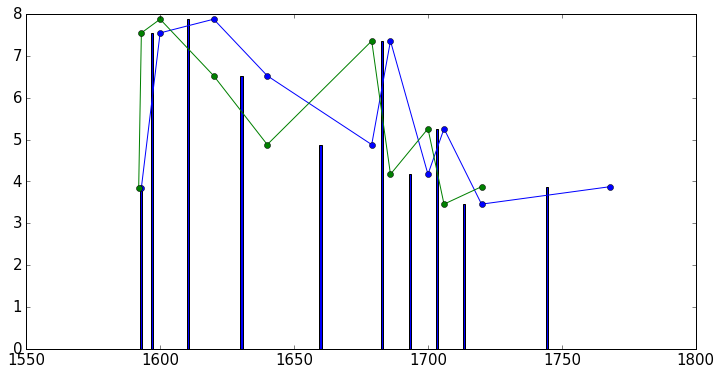

In [190]:
plt.plot(years, y_, marker='o', lw=1)
plt.plot(years_[:-1], y_, marker='o', lw=1)
plt.bar(years_mid, y_)

In [173]:
l_pos_ind = np.where(l_ > 0)
l_0_ind = np.where(l_ == 0)
l_neg_ind = np.where(l_ < 0)

In [174]:
max_width = 20
bar_width = years_dif
#bar_width = np.clip(bar_width, 0, max_width)

IndexError: index 10 is out of bounds for axis 1 with size 10

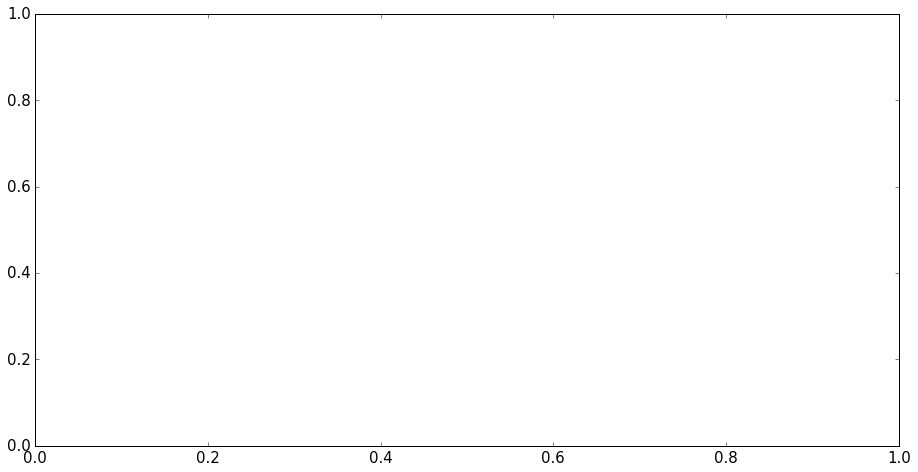

In [175]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.bar(years_mid[l_pos_ind], l_[l_pos_ind], bar_width[l_pos_ind], color='r', edgecolor='none')
plt.bar(years_mid[l_neg_ind], l_[l_neg_ind], bar_width[l_neg_ind], color='g', edgecolor='none')
plt.bar(years_mid[l_0_ind], np.zeros(l_0_ind[0].size)+50, bar_width[l_0_ind], color='b', edgecolor='none')
ax = plt.gca().twinx()
ax.plot(lengths_data.dl)

NameError: name 'l_pos_ind' is not defined

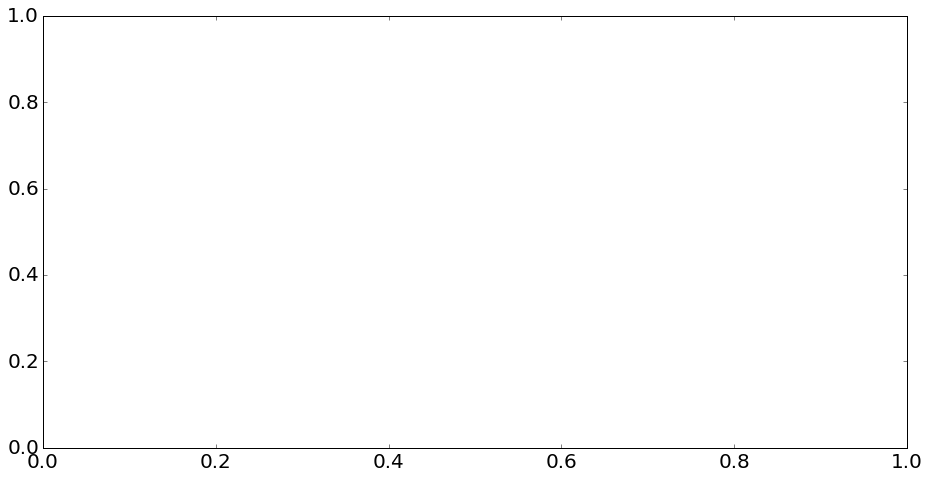

In [55]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.bar(years[l_pos_ind], l_[l_pos_ind])
ax = plt.gca().twinx()
ax.plot(lengths_data.dl)

In [56]:
lengths_data['l'] = l_

NameError: name 'l_' is not defined

In [88]:
l_[:ind_1880].sum()

-820.0

In [90]:
print(l_[:ind_1880])

[   0.    0.    0. -250. -450.  140.    0.  120.  180. -320.  272.  130.
   20.   50. -200. -150.  -60.  120.   80.  -30.  310.    0.  -60.  -20.
  -30.   30.  110.    0.  -30. -210. -170. -402.]


In [79]:
lengths_data.l.loc[:1879].sum()

-418.0

In [58]:
print(lengths_data.iloc[:ind_1880+20])

NameError: name 'ind_1880' is not defined

In [57]:
dl = lengths_data.dl
del lengths_data['dl']
lengths_data['dl'] = dl

In [108]:
years_mid

Float64Index([1596.5, 1610.0, 1630.0, 1659.5, 1682.5, 1693.0, 1703.0, 1713.0,
              1744.0, 1770.5,
              ...
              1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2004.5, 2010.5, 2012.5,
              2013.5, 2014.5],
             dtype='float64', name='year', length=133)

Int64Index([1593, 1600, 1620, 1640, 1679, 1686, 1700, 1706, 1720, 1768,
            ...
            1995, 1996, 1997, 1998, 1999, 2000, 2009, 2012, 2013, 2014],
           dtype='int64', name='year', length=133)

In [493]:
a = np.random.rand(10)
b = np.random.rand(10)

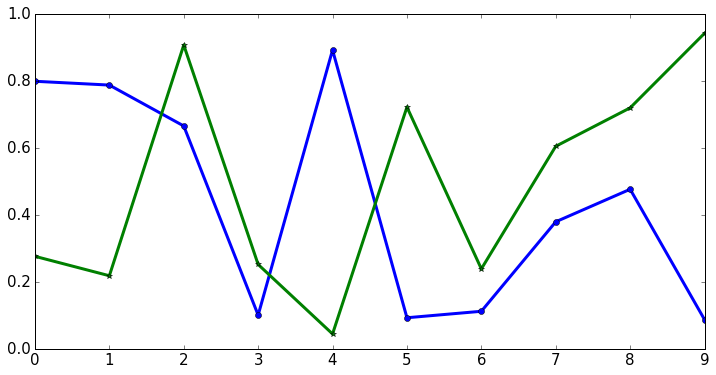

In [494]:
plt.plot(a, 'o-')
plt.plot(b, '*-')

In [497]:
def calc_rms(a,b):
    n = a.size
    return np.sqrt(np.sum((a-b)**2)/n)

In [498]:
calc_rms(a,b)

0.51495882189198672

In [502]:
lenght_file = utils.get_demo_file('grindelwald_lengths.csv')
lengths_data = pd.read_csv(lenght_file, index_col=0)

In [504]:
ls /Users/oberrauch/.oggm/oggm-sample-data-master/test-files/grindelwald_lengths.csv

/Users/oberrauch/.oggm/oggm-sample-data-master/test-files/grindelwald_lengths.csv


In [500]:
lengths_data

dl
year     
1593  820
1600  820
1620  820
1640  570
1679  120
1686  260
1700  260
1706  380
1720  560
1768  240
1773  512
1776  642
1777  662
1778  712
1786  512
1792  362
1803  302
1810  422
1813  502
1815  472
1820  782
1822  782
1826  722
1832  702
1838  672
1840  702
1854  812
1855  812
1856  782
1862  572
...   ...
1971 -128
1972  -60
1973  -20
1974   15
1975   32
1976   32
1977   44
1978   50
1979   57
1980   64
1981   86
1982  151
1983  187
1984  187
1985  212
1986  197
1987  213
1988  211
1989  191
1990  182
1991  129
1992   79
1993   19
1994  -43
1995  -50
1996 -120
1997 -130
1998 -145
1999 -170
2000 -220

[129 rows x 1 columns]